In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)

    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        print(fs[i], np.shape(df[fs[i]].values), df[fs[i]].values[0])
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])
            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                #print(np.shape(paras))
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        kinages = df_common['kin_age'].values
        m = (kinages!=kinages)
        kinages[m] = -999
        df_common['kin_age'] = kinages
        df_test = df_common
        
        if count==0:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    kinages = df_common['kin_age'].values
    m = (kinages!=kinages)
    kinages[m] = -999
    df_common['kin_age'] = kinages
        
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]

    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq

    

        

def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

def calc_tc(teff):
    return 314.24*np.exp(-(teff/1952.5)-(teff/6250)**18)+0.002



def LouisTurnoverTime(Teff):
    if (Teff<=3480.):
        tauLouis = 10.**(6.52112823e-7*Teff**2. - 4.00355099e-3*Teff + 8.68234621)
    else:
        tauLouis = 10.**(-2.51904051e-10*Teff**3. + 3.73613409e-6*Teff**2. - 1.85566042e-2*Teff + 32.5950535)
    #renormalise to CS11 scale
    tau = tauLouis*13.79/35.54
 
    return tau


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
df = pd.read_pickle('./NewKinAge.pkl')

In [3]:
df.columns

Index(['KIC_x', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2',
       ...
       'kin_age_err_AVR', 'τc', 'abs_G_rot', 'teff_rot', 'teff_calc_new',
       'abs_G_rot_new', 'kin_age_ave', 'dist', 'iso_age_ave',
       'iso_age_ave_err'],
      dtype='object', length=266)

In [ ]:
from astropy.io import fits
hdul = fits.open('dr3-rv-good-plx-MilkyWayPotential2022-joined.fits')
data = hdul[1].data

In [ ]:
cols = hdul[1].columns
cols

In [ ]:
#np.shape(data['vxyz'])

In [ ]:
#m = (data['ruwe']<1.4)
#print(sum(m))

In [ ]:
sourceid = ['GAIA_DR3 '+str(i) for i in data['source_id']]


In [ ]:
dr3 = pd.DataFrame(np.array((sourceid, data['L'][:,2])).T,
                  columns=['source_id','Lz'])


In [ ]:
dr3.to_pickle('dr3_Lz.pkl')

In [ ]:
pwd

In [5]:
dr3 = pd.DataFrame(np.array((data['xyz'][:,0], data['xyz'][:,1], data['xyz'][:,2],
                            data['vxyz'][:,0], data['vxyz'][:,1], data['vxyz'][:,2],
                            sourceid, data['ra'], data['dec'],
                            data['astrophysical_parameters_mh_gspphot'])).T,
                  columns=['x','y','z','vx','vy','vz','source_id','ra','dec','feh'])

In [6]:
dr3.to_pickle('dr3_kinematic.pkl')

In [17]:
type(data['source_id'][0])

numpy.int64

In [11]:
#df = pd.read_pickle('dr3_kinematic.pkl')

# Read in data

In [6]:
dr3 = pd.read_pickle('dr3_kinematic.pkl')

# Kepler dr3 RVs

In [8]:
dr3['dec'] = np.array(dr3['dec'], dtype=float)
dr3['ra'] = np.array(dr3['ra'], dtype=float)


In [9]:
dr3_kepler = dr3.loc[(dr3['dec']>min(df['dec']))&(dr3['dec']<max(df['dec']))].reset_index(drop=True)
dr3_kepler = dr3_kepler.loc[(dr3_kepler['ra']>min(df['ra']))&(dr3_kepler['ra']<max(df['ra']))].reset_index(drop=True)
dr3_kepler


x                    y                    z  \
0        -7.896421924388291   0.6732742014323405  0.08901273320902596   
1        -6.142824808296177      5.9356441893029   0.6116550074600942   
2       -7.8885312492815185   0.7005262850464354  0.09055081004729058   
3        -5.980500068998321    6.416840672752284   0.6634322347735001   
4        -7.377207207001054   2.2332371896947962  0.24384798175708922   
...                     ...                  ...                  ...   
345447   -7.963750777732898     1.10271671790987  0.46510806827706674   
345448   -7.983801574003988   0.9571703815491063  0.40722550138025865   
345449   -8.088780175547996  0.23112902073991204  0.11423014309655292   
345450   -7.940292171989046   1.2590363461774814    0.530713087490232   
345451   -7.845926287220084   1.9530022281331447   0.7935347873374926   

                         vx                  vy                   vz  \
0       -29.739869678048453  230.05823988193396     7.26565474186534   
1        216.62296538347482  105.41111521294917     6.78768516175641   
2         35.84097995421007   227.5672773846911    6.795759265308711   
3        223.18087111114892  140.67237879856526    18.55562954557926   
4         66.34975767333123  236.15179274216106   12.294220071832848   
...                     ...                 ...                  ...   
345447    59.07749707553129  214.39109855231453  -6.0207858176513165   
345448    77.63850301613458  234.07443650440916  -31.327451122395548   
345449   42.772281623012795   232.4000743720983    40.85291597455633   
345450    27.68870117927069   216.7427384647385   -29.64924854825448   
345451    71.80601524522115  203.16104590677733   -12.76926563952869   

                           source_id          ra        dec      feh  
0       GAIA_DR3 2047934934694606976  297.069139  36.594729      nan  
1       GAIA_DR3 2047935759328218112  297.219587  36.617978      nan  
2       GAIA_DR3 2047935759328220032  297.224063  36.627545  -0.0188  
3       GAIA_DR3 2047935896767205888  297.175630  36.621086      nan  
4       GAIA_DR3 2047935931126929280  297.198517  36.624394  -0.1761  
...                              ...         ...        ...      ...  
345447  GAIA_DR3 2146267798595609728  281.864608  52.420336  -0.1695  
345448  GAIA_DR3 2146269276064340736  281.785910  52.387428  -0.3804  
345449  GAIA_DR3 2146269482222776960  281.761195  52.432297  -0.0758  
345450  GAIA_DR3 2146269963259097856  281.688291  52.408170      nan  
345451  GAIA_DR3 2146281886088287360  282.467216  52.424774  -0.5398  

[345452 rows x 10 columns]

In [10]:
df = df.dropna(subset=['ra','dec','KIC_x']).reset_index(drop=True)
dr3_kepler = dr3_kepler.dropna(subset=['ra','dec','source_id']).reset_index(drop=True)


In [11]:
print(len(df), len(dr3_kepler))

27687 345452


In [12]:
df3_kepler_cm = crossmatch(df[['ra','dec','KIC_x']], 
                           dr3_kepler[['ra','dec','source_id']])


/Users/yl4331/Desktop/NewGyroKineage/HeaderP.py:1346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1df2[i]=df1.iloc[idx][i].values
/Users/yl4331/Desktop/NewGyroKineage/HeaderP.py:1346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1df2[i]=df1.iloc[idx][i].values


In [13]:
df3_kepler_cm

ra        dec                     source_id       KIC_x
8223    295.325712  38.556871  GAIA_DR3 2049136082423106432   3459775.0
8226    295.344850  38.566953  GAIA_DR3 2049136254223300224   3459866.0
8234    295.269705  38.559793  GAIA_DR3 2049136735258093056   3459504.0
8243    295.304902  38.634667  GAIA_DR3 2049137594251630080   3560479.0
8266    291.312529  36.633194  GAIA_DR3 2050190548423109248    893507.0
...            ...        ...                           ...         ...
340141  282.768093  48.877913  GAIA_DR3 2143762904950009344  11175768.0
340153  282.618155  48.779987  GAIA_DR3 2143766375283526272  11122057.0
340226  282.119717  48.636747  GAIA_DR3 2143784654664196608  11067986.0
340227  282.084844  48.666073  GAIA_DR3 2143785582377134208  11067941.0
340493  283.042209  48.956724  GAIA_DR3 2143854439292601344  11229244.0

[14217 rows x 4 columns]

In [14]:
kepler_vz_ruth = df.loc[df['KIC_x'].isin(df3_kepler_cm['KIC_x'])].reset_index(drop=True)
kepler_vz_dr3 = dr3.loc[dr3['source_id'].isin(df3_kepler_cm['source_id'])].reset_index(drop=True)



In [15]:
kepler_vz_ruth['vz_dr2'] = kepler_vz_ruth['vz']

In [16]:
kepler_all_rv_dr3 = pd.merge(df3_kepler_cm, 
                             kepler_vz_ruth[['KIC_x', 'vz_inferred', 'vz_dr2',
                                            'Prot','kin_age','bp_rp']], 
                             left_on = 'KIC_x', right_on = 'KIC_x',
                            how = 'inner')

kepler_all_rv_dr3 = pd.merge(kepler_all_rv_dr3, kepler_vz_dr3, left_on = 'source_id',
                            right_on = 'source_id', how = 'inner')


In [22]:
kepler_all_rv_dr3['vz'] = np.array(kepler_all_rv_dr3['vz'], dtype='float')
kepler_all_rv_dr3['feh'] = np.array(kepler_all_rv_dr3['feh'], dtype='float')

3.6796158340703204


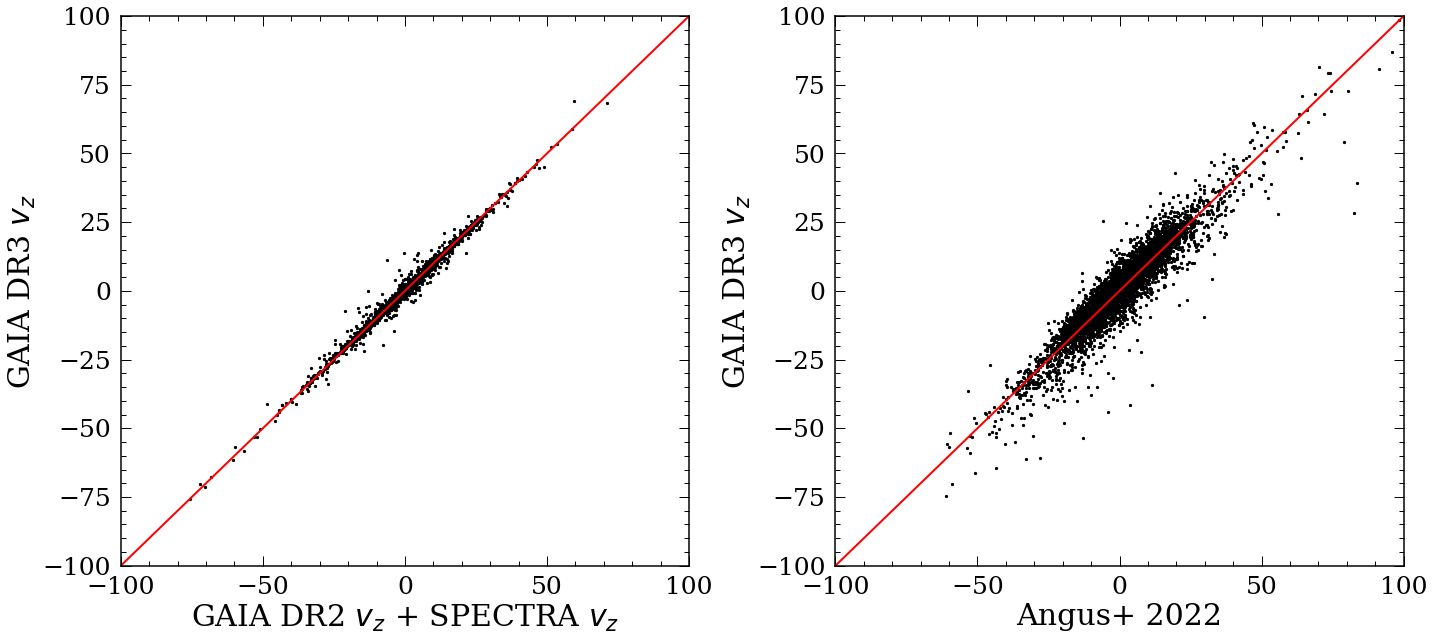

In [20]:
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.scatter(kepler_all_rv_dr3['vz_dr2'], kepler_all_rv_dr3['vz'], c='k', s=5)
plt.xlabel('GAIA DR2 $v_z$ + SPECTRA $v_z$')
plt.ylabel('GAIA DR3 $v_z$')
plt.plot([-100,100], [-100,100], 'r-')
plt.xlim([-100, 100])
plt.ylim([-100, 100])

plt.subplot(1,2,2)
plt.scatter(kepler_all_rv_dr3['vz_inferred'], kepler_all_rv_dr3['vz'], c='k', s=5)
print(np.mean(abs(kepler_all_rv_dr3['vz_inferred']-kepler_all_rv_dr3['vz'])))
plt.xlabel('Angus+ 2022')
plt.ylabel('GAIA DR3 $v_z$')
plt.plot([-100,100], [-100,100], 'r-')
plt.xlim([-100, 100])
plt.ylim([-100, 100])

plt.tight_layout()

Text(0, 0.5, 'Period [Days]')

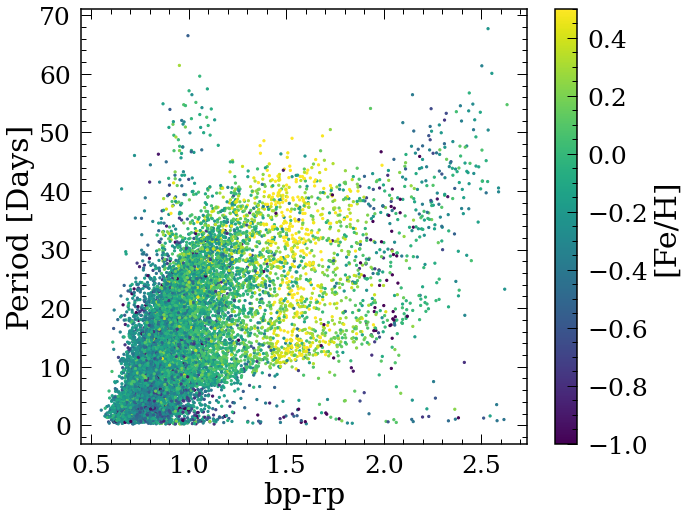

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(kepler_all_rv_dr3['bp_rp'], kepler_all_rv_dr3['Prot'],
            c=kepler_all_rv_dr3['feh'],vmin=-1,
          vmax=0.5,s=5)
cb = plt.colorbar()
cb.set_label('[Fe/H]')    
plt.xlabel('bp-rp')
plt.ylabel('Period [Days]')

Text(0, 0.5, 'Gyr-kinematic Age [Gyr]')

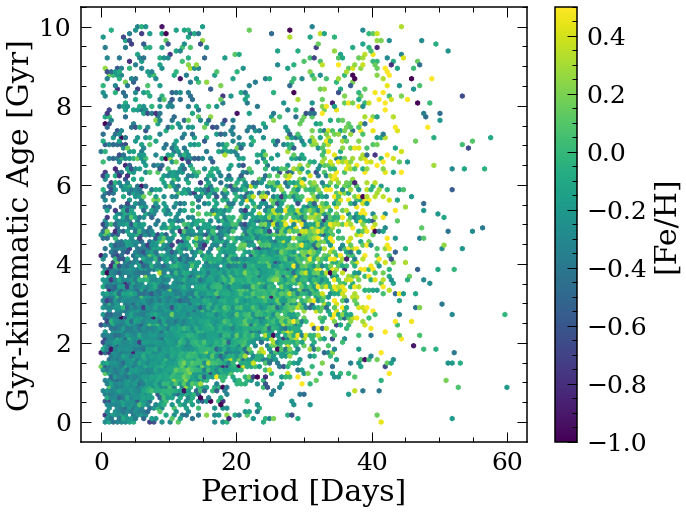

In [24]:
plt.figure(figsize=(10,8))
plt.hexbin(kepler_all_rv_dr3['Prot'], kepler_all_rv_dr3['kin_age'],
          C=kepler_all_rv_dr3['feh'],extent=(0,60,0,10),vmin=-1,
          vmax=0.5)
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.xlabel('Period [Days]')
plt.ylabel('Gyr-kinematic Age [Gyr]')


# ZTF dr3 RVs

In [2]:
#ztf = pd.read_pickle('/Users/yl4331/Desktop/ZTF/osg/ZTF_gaiaCross/ZTFgoodProt.pkl')
ztf = pd.read_pickle('/Users/yl4331/Desktop/ZTF/osg/ZTF_gaiaCross/twosame.pkl')

In [3]:
ztf.columns

Index(['gaiaid', 'bprp', 'gmag', 'rv', 'id', 'ra', 'dec', 'prot1', 'prot2',
       'prot3', 'prot4', 'prot5', 'prot6', 'prot7', 'maxpower1', 'maxpower2',
       'maxpower3', 'maxpower4', 'maxpower5', 'maxpower6', 'maxpower7',
       'medpower_org', 'medpower1', 'medpower2', 'medpower3', 'medpower4',
       'medpower5', 'medpower6', 'medpower7', 'nl', 'dt', 'tt', 'filename',
       'maxpower_un1', 'maxpower_un2', 'maxpower_un3', 'maxpower_un4',
       'maxpower_un5', 'maxpower_un6', 'maxpower_un7', 'SN1', 'SN2', 'SN3',
       'SN4', 'SN5', 'SN6', 'SN7', 'maxpowers', 'maxpowerprot', 'maxSN',
       '2agree', 'prot0', 'sameprot'],
      dtype='object')

In [4]:
ztf = ztf.loc[ztf['sameprot']>10].reset_index(drop=True)

In [5]:
len(ztf), len(ztf.drop_duplicates('gaiaid'))

(892453, 439217)

In [31]:
# select gaia stars 
ztf_gaia = dr3.loc[(dr3['dec']>min(ztf['dec']))&(dr3['dec']<max(ztf['dec']))].reset_index(drop=True)
ztf_gaia = ztf_gaia.loc[(ztf_gaia['ra']>min(ztf['ra']))&(ztf_gaia['ra']<max(ztf['ra']))].reset_index(drop=True)
ztf_gaia

x                     y                     z  \
0         -8.334797624651799  0.012275024294322196  -0.22160047921258375   
1         -8.788042234393993  0.037940356543780425   -0.7370808125740804   
2          -8.22808623804902  0.005932358222967345  -0.09958577731355973   
3         -8.372214284488068  0.014040038638240541  -0.26291228014163026   
4         -8.239901198980004  0.006696957170253244  -0.11302760610124771   
...                      ...                   ...                   ...   
12368788  -7.857309847885574    0.6596822390460608   0.37908356064240617   
12368789  -7.990728665116022   0.32722517901953974   0.19866988293614546   
12368790  -7.953564671252258    0.4209377944358596   0.24903254863980603   
12368791  -7.856779479497817    0.6628650005158007    0.3805943223800796   
12368792  -7.770232134582472    0.8812609676563309    0.4998160935117716   

                           vx                  vy                  vz  \
0         -3.9137578081095237  163.03746588067642   21.81616722447504   
1           43.91331246669447   171.7215700241731   9.099227001757997   
2         -19.003349213037442   259.0729584146978   34.27019810164992   
3          21.469869279829766  217.35357977746827  -8.411754490210368   
4         -10.429046978498556   215.9590712233415  18.983340915804618   
...                       ...                 ...                 ...   
12368788   10.318023599161613  224.96338706796288   49.64693187424985   
12368789   -9.311445648362008  159.45653004097315  -22.31986856883145   
12368790   17.460850076951843  236.17168790108443   31.91469345603056   
12368791  -31.296169055532104  243.39136533187522  -4.504438105038283   
12368792    64.24930999975554  172.31887371756352   5.035986430568571   

                             source_id          ra        dec      feh  
0               GAIA_DR3 6223408420864   44.937649   0.188393  -0.1791  
1               GAIA_DR3 6944962925824   44.975822   0.187814  -0.0687  
2               GAIA_DR3 7284264691456   45.062277   0.216004      nan  
3               GAIA_DR3 7387343906304   45.070767   0.234734   0.1539  
4               GAIA_DR3 7632157690368   45.034343   0.235390  -0.1016  
...                                ...         ...        ...      ...  
12368788  GAIA_DR3 4611683858061500544  270.002504  41.635189  -0.3184  
12368789  GAIA_DR3 4611684098579672064  269.977847  41.644885  -0.5557  
12368790  GAIA_DR3 4611684407817314688  270.057078  41.676013  -0.3049  
12368791  GAIA_DR3 4611684442177055872  270.024732  41.682248  -0.5455  
12368792  GAIA_DR3 4611685541688687360  269.985591  41.731954      nan  

[12368793 rows x 10 columns]

In [41]:
ztf_gaia['source_id'] = [i.split('GAIA_DR3 ')[1] for i in ztf_gaia['source_id']]

In [46]:
ztf_gaia['source_id'] = np.array(ztf_gaia['source_id'], dtype=int)
ztf['gaiaid'] = np.array(ztf['gaiaid'], dtype=int)


In [47]:
df3_ztf_cm = ztf_gaia.loc[ztf_gaia['source_id'].isin(ztf['gaiaid'])]


In [51]:
len(df3_ztf_cm['source_id'].unique())

56943

In [52]:
ztf_all_rv_cm = pd.merge(df3_ztf_cm, ztf, left_on='source_id', right_on='gaiaid',
                        how='inner')
len(ztf_all_rv_cm)

119303

In [53]:
#ztf_all_rv_cm.to_pickle('gaia_dr3_ztf_twosame.pkl')

In [147]:
#gaiadata.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'gmag', 'bp_rp',
       'pmra', 'pmdec', 'dr2_radial_velocity', 'dr2_radial_velocity_error',
       'ruwe', 'abs_G', 'ZTFobsNumb', 'ZTF_g_lc_Numb', 'ZTF_r_lc_Numb',
       'ZTF_i_lc_Numb', 'phot_rp_mean_mag', 'ebv', 'Av', 'Av_errp', 'Av_errm',
       'Av_std', 'bprp_dered', 'G_dered', 'abs_G_dered'],
      dtype='object')

In [415]:
#gaiadata['bprp_dered']
ztf_all_rv_cm = pd.read_pickle('gaia_dr3_ztf_twosame.pkl')

In [416]:
gaiadata = pd.read_pickle('/Users/yl4331/Desktop/ZTF/osg/ZTF_gaiaCross/gaia_obsnumb_absg7.pkl')
print(len(ztf_all_rv_cm))
ztf_all_rv_cm = pd.merge(ztf_all_rv_cm, gaiadata[['abs_G','source_id','bprp_dered','parallax','abs_G_dered']],
                         left_on='source_id', right_on='source_id', how='inner')
print(len(ztf_all_rv_cm))

119303
119303


In [417]:
ztf_all_rv_cm['vz'] = np.array(ztf_all_rv_cm['vz'], dtype='float')

<AxesSubplot:>

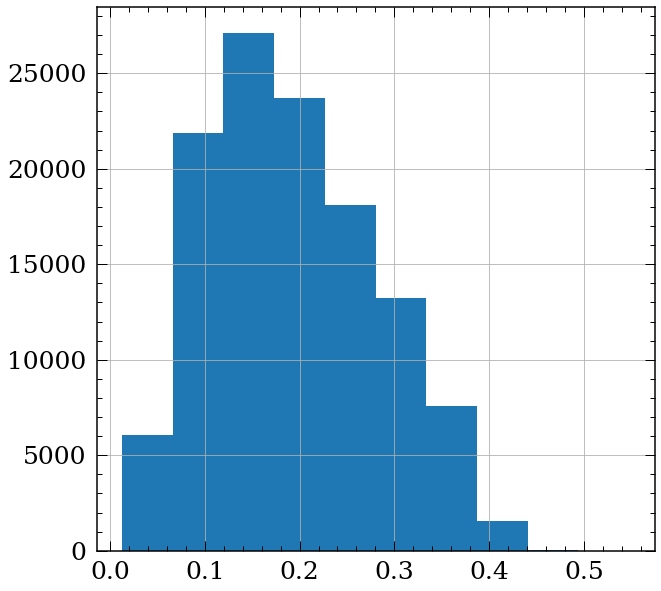

In [418]:
(1/ztf_all_rv_cm['parallax']).hist()

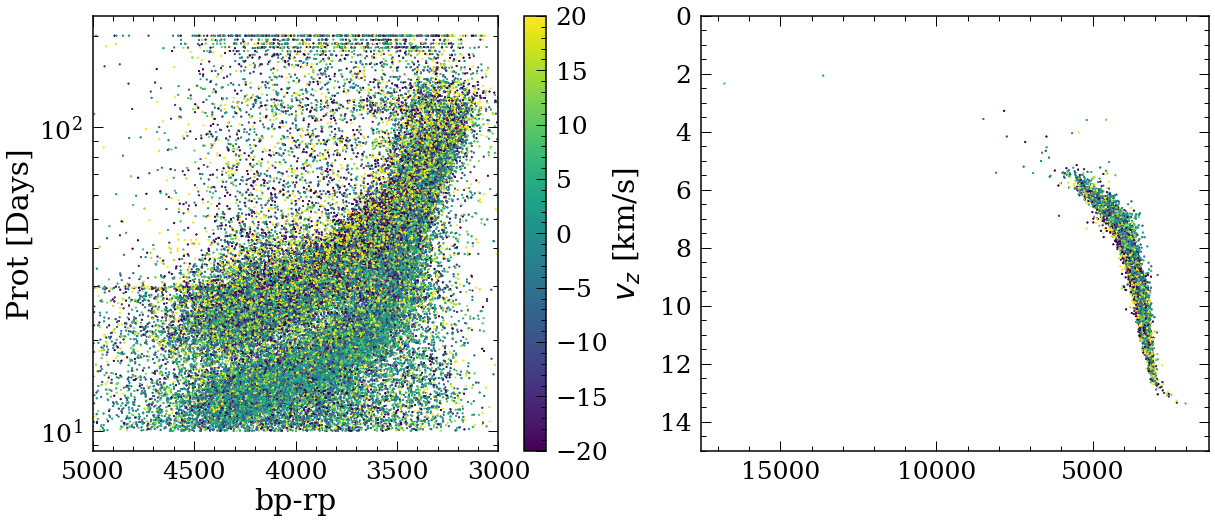

In [419]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
ztf_all_rv_cm['teff_calc'] = bprp_to_teff(ztf_all_rv_cm['bprp_dered'])

plt.scatter(ztf_all_rv_cm['teff_calc'], ztf_all_rv_cm['sameprot'], 
            c=ztf_all_rv_cm['vz'], s=1, vmin=-20, vmax=20)
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('$v_z$ [km/s]')
plt.xlabel('bp-rp')
plt.ylabel('Prot [Days]')
plt.xlim([5000, 3000])

plt.subplot(1,2,2)
plt.scatter(ztf_all_rv_cm['teff_calc'], ztf_all_rv_cm['abs_G_dered'], 
            c=ztf_all_rv_cm['vz'], s=1, vmin=-20, vmax=20)

plt.ylim([0,15])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

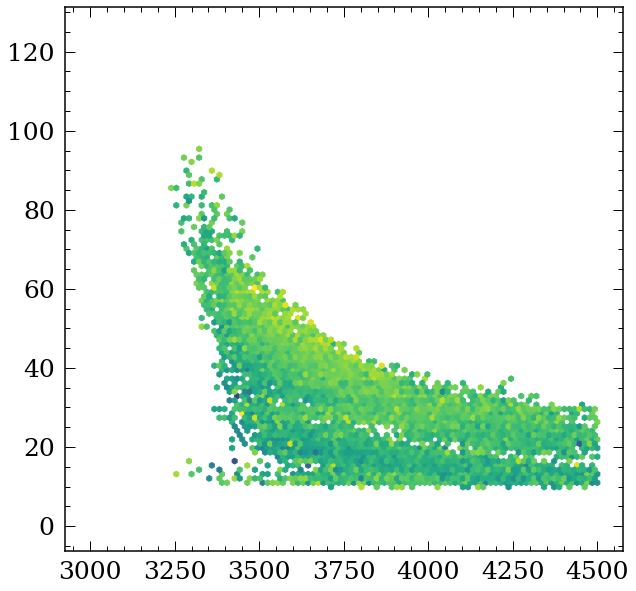

In [420]:
plt.hexbin(ztf_all_rv_cm['teff_calc'], ztf_all_rv_cm['sameprot'], 
            C=ztf_all_rv_cm['vz'], reduce_C_function=np.std, 
          vmin=1,vmax=50, gridsize=100, bins='log',mincnt=15,
          extent=(3000,4500,0,125))


In [421]:
#ztf_all_rv_cm.to_pickle('ZTF_dr3_twosame.pkl')

In [422]:
ztf_all_rv_cm.columns


Index(['x', 'y', 'z', 'vx', 'vy', 'vz', 'source_id', 'ra_x', 'dec_x', 'feh',
       'gaiaid', 'bprp', 'gmag', 'rv', 'id', 'ra_y', 'dec_y', 'prot1', 'prot2',
       'prot3', 'prot4', 'prot5', 'prot6', 'prot7', 'maxpower1', 'maxpower2',
       'maxpower3', 'maxpower4', 'maxpower5', 'maxpower6', 'maxpower7',
       'medpower_org', 'medpower1', 'medpower2', 'medpower3', 'medpower4',
       'medpower5', 'medpower6', 'medpower7', 'nl', 'dt', 'tt', 'filename',
       'maxpower_un1', 'maxpower_un2', 'maxpower_un3', 'maxpower_un4',
       'maxpower_un5', 'maxpower_un6', 'maxpower_un7', 'SN1', 'SN2', 'SN3',
       'SN4', 'SN5', 'SN6', 'SN7', 'maxpowers', 'maxpowerprot', 'maxSN',
       '2agree', 'prot0', 'sameprot', 'abs_G', 'bprp_dered', 'parallax',
       'abs_G_dered', 'teff_calc'],
      dtype='object')

(5000.0, 3000.0)

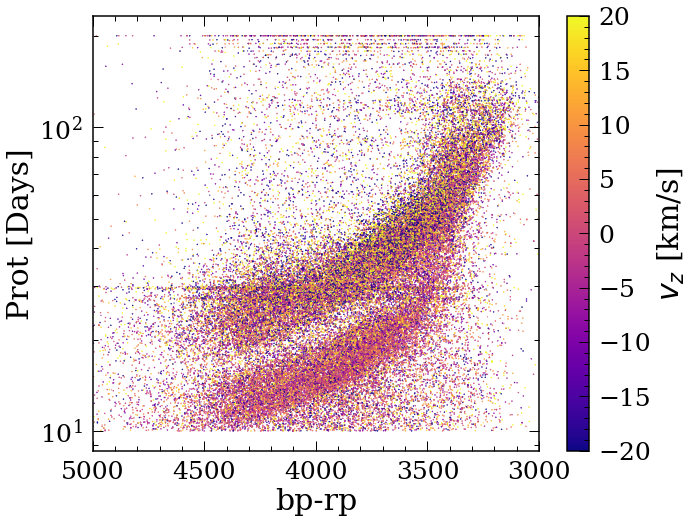

In [423]:
plt.figure(figsize=(10,8))
plt.scatter(ztf_all_rv_cm['teff_calc'], ztf_all_rv_cm['sameprot'], 
            c=ztf_all_rv_cm['vz'], s=0.1, vmin=-20, vmax=20,
           cmap='plasma')
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('$v_z$ [km/s]')
plt.xlabel('bp-rp')
plt.ylabel('Prot [Days]')
plt.xlim([5000, 3000])


# Cheng+ 2020 ztf periods

In [424]:
ztf_cheng_v = pd.read_pickle('/Users/yl4331/Desktop/ZTF/osg/ZTF_gaiaCross/cheng2020varible.pkl')
ztf_cheng_v = ztf_cheng_v.loc[ztf_cheng_v['Per-r']>10].reset_index(drop=True)
ztf_cheng_v = ztf_cheng_v.loc[~ztf_cheng_v['source_id'].isin(ztf['gaiaid'])].reset_index(drop=True)

In [425]:
ztf_cheng_nv = pd.read_pickle('/Users/yl4331/Desktop/ZTF/osg/ZTF_gaiaCross/cheng2020susvarible.pkl')
ztf_cheng_nv = ztf_cheng_nv.loc[ztf_cheng_nv['Per-r']>10].reset_index(drop=True)
ztf_cheng_nv = ztf_cheng_nv.loc[~ztf_cheng_nv['source_id'].isin(ztf['gaiaid'])].reset_index(drop=True)


In [426]:
ztf_cheng = pd.concat([ztf_cheng_nv, ztf_cheng_v])
len(ztf_cheng)

3041

In [427]:
ztf_cheng_gaia = dr3.loc[(dr3['dec']>min(ztf_cheng['dec']))&(dr3['dec']<max(ztf_cheng['dec']))].reset_index(drop=True)
ztf_cheng_gaia = ztf_cheng_gaia.loc[(ztf_cheng_gaia['ra']>min(ztf_cheng['ra']))&(ztf_cheng_gaia['ra']<max(ztf_cheng['ra']))].reset_index(drop=True)
ztf_cheng_gaia


x                     y                     z  \
0         -8.815758080535495   0.03768991084990561   -0.7468459959765168   
1         -8.348639688884099  0.012629494099958768   -0.2300642976483349   
2         -8.302758244865135    0.0108589367220975  -0.18100205473749953   
3         -8.656494760215397   0.03226040874698468    -0.575951147750154   
4         -8.467098145141618  0.019957967309567472   -0.3618643667254324   
...                      ...                   ...                   ...   
12123515  -7.857309847885574    0.6596822390460608   0.37908356064240617   
12123516  -7.990728665116022   0.32722517901953974   0.19866988293614546   
12123517  -7.953564671252258    0.4209377944358596   0.24903254863980603   
12123518  -7.856779479497817    0.6628650005158007    0.3805943223800796   
12123519  -7.770232134582472    0.8812609676563309    0.4998160935117716   

                           vx                  vy                   vz  \
0          20.166239126651718  233.30183262819259    2.925345097461106   
1          40.376941793576385  248.88251917768727  -15.738349964087705   
2         -40.025922207079226  251.56196919882336   -4.081932397294223   
3          -85.54223604091385  229.72025551983907   -7.377331585072225   
4          -74.30747196358963   157.7293856074125  -19.568599325168673   
...                       ...                 ...                  ...   
12123515   10.318023599161613  224.96338706796288    49.64693187424985   
12123516   -9.311445648362008  159.45653004097315   -22.31986856883145   
12123517   17.460850076951843  236.17168790108443    31.91469345603056   
12123518  -31.296169055532104  243.39136533187522   -4.504438105038283   
12123519    64.24930999975554  172.31887371756352    5.035986430568571   

                             source_id          ra        dec      feh  
0              GAIA_DR3 48348447666944   45.614895   0.666014  -0.7705  
1              GAIA_DR3 51646982549632   45.573903   0.700679    0.497  
2              GAIA_DR3 62951336478592   45.288508   0.655430   0.0004  
3              GAIA_DR3 62951336478720   45.278153   0.660694  -0.9281  
4              GAIA_DR3 64325726008320   45.482879   0.725044      nan  
...                                ...         ...        ...      ...  
12123515  GAIA_DR3 4611683858061500544  270.002504  41.635189  -0.3184  
12123516  GAIA_DR3 4611684098579672064  269.977847  41.644885  -0.5557  
12123517  GAIA_DR3 4611684407817314688  270.057078  41.676013  -0.3049  
12123518  GAIA_DR3 4611684442177055872  270.024732  41.682248  -0.5455  
12123519  GAIA_DR3 4611685541688687360  269.985591  41.731954      nan  

[12123520 rows x 10 columns]

In [428]:
ztf_cheng_gaia['source_id'] = [int(i.split('GAIA_DR3 ')[1]) for i in ztf_cheng_gaia['source_id']]

In [429]:
ztf_cheng_gaia_cm = ztf_cheng_gaia.loc[ztf_cheng_gaia['source_id'].isin(ztf_cheng['source_id'])]
ztf_cheng_gaia_cm = pd.merge(ztf_cheng_gaia_cm, ztf_cheng, left_on='source_id', right_on='source_id',
                        how='inner')
len(ztf_cheng_gaia_cm)


529

In [430]:
print(len(ztf_cheng_gaia_cm))
ztf_cheng_gaia_cm = pd.merge(ztf_cheng_gaia_cm, gaiadata[['source_id']],
                         left_on='source_id', right_on='source_id', how='inner')
print(len(ztf_cheng_gaia_cm))


529
529


In [431]:
ztf_cheng_gaia_cm['teff_calc'] = bprp_to_teff(ztf_cheng_gaia_cm['bp_rp'])

# combine kepler and ztf

In [706]:
df = pd.read_pickle('./NewKinAge.pkl')
df


KIC_x  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  \
0       5608002.0     0.463          0.023         -0.023    3604.0   
1      11876227.0     0.426          0.011         -0.011    3551.1   
2      12505701.0     0.450          0.010         -0.011    3605.1   
3       7352892.0     0.255          0.007         -0.007    3413.6   
4       7022137.0     0.377          0.010         -0.009    3496.3   
...           ...       ...            ...            ...       ...   
27709   5209980.0     1.418          0.049         -0.057    7302.6   
27710   5823587.0     1.568          0.053         -0.071    7888.7   
27711   9047437.0     1.654          0.079         -0.082    7968.1   
27712   9052849.0     1.842          0.097         -0.101    8006.9   
27713   9240041.0     1.465          0.078         -0.066    7443.2   

       iso_teff_err1  iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  \
0               79.9          -76.1     4.747          0.020         -0.020   
1               70.0          -74.1     4.780          0.010         -0.010   
2               76.7          -77.1     4.762          0.010         -0.010   
3               63.3          -91.4     4.933          0.008         -0.008   
4               76.8          -64.1     4.820          0.009         -0.009   
...              ...            ...       ...            ...            ...   
27709          172.4         -165.9     4.296          0.025         -0.029   
27710          187.0         -174.7     4.289          0.022         -0.027   
27711          199.0         -177.4     4.213          0.031         -0.034   
27712          223.5         -244.2     4.059          0.032         -0.034   
27713          175.5         -167.8     4.230          0.031         -0.031   

       ...  kin_age_err_AVR         τc  abs_G_rot     teff_rot  teff_calc_new  \
0      ...         0.300872  56.455137   7.101975  3351.917424    3341.001444   
1      ...         0.191533  56.420986   7.376605  3353.098369    3334.772398   
2      ...         0.993635  56.375111   7.397325  3354.686364    3298.253890   
3      ...         0.387578  55.980041   8.618305  3368.414196    3357.835765   
4      ...         0.687034  55.766384   7.787833  3375.880744    3373.564270   
...    ...              ...        ...        ...          ...            ...   
27709  ...         0.000597   0.002000   6.597271  7713.290177    7732.178329   
27710  ...         2.033992   0.002000   6.481491  7821.861224    7668.397641   
27711  ...         0.494272   0.002000   6.262783  7893.325826    7910.149228   
27712  ...         0.026092   0.002000   5.846641  7894.619419    7899.984377   
27713  ...         1.262116   0.002000   6.598259  7969.545344    8187.893972   

       abs_G_rot_new  kin_age_ave          dist  iso_age_ave  iso_age_ave_err  
0           6.990490          NaN  1.558304e+05    10.803393         0.180000  
1           7.393351          NaN  1.550636e+05    10.592302         0.064743  
2           7.413805     6.046266  1.542159e+05    10.375747         0.095674  
3           8.605230          NaN  1.431931e+05     9.895023         0.005000  
4           7.778166          NaN  1.389102e+05     9.790920         0.078372  
...              ...          ...           ...          ...              ...  
27709       6.614474          NaN  1.573882e+07     0.460000         0.000000  
27710       6.463063          NaN  1.661206e+07     0.370000         0.000000  
27711       6.281524          NaN  1.719972e+07     0.590000         0.000000  
27712       5.804935          NaN  1.721047e+07     0.710000         0.000000  
27713       6.624107          NaN  1.783771e+07     0.870000         0.000000  

[27714 rows x 266 columns]

In [707]:
df['vz'] = df['all_vz']

ztf_all_rv_cm['Prot'] = ztf_all_rv_cm['sameprot']
ztf_all_rv_cm['KIC_x'] = np.nan*np.ones(len(ztf_all_rv_cm))

ztf_cheng_gaia_cm['Prot'] = ztf_cheng_gaia_cm['Per-r']
ztf_cheng_gaia_cm['KIC_x'] = np.nan*np.ones(len(ztf_cheng_gaia_cm))
ztf_cheng_gaia_cm['gaiaid'] = ztf_cheng_gaia_cm['source_id']

print(len(ztf_all_rv_cm)+len(ztf_cheng_gaia_cm))

57472


In [708]:
#np.hist(ztf_all_rv_cm['parallex'])


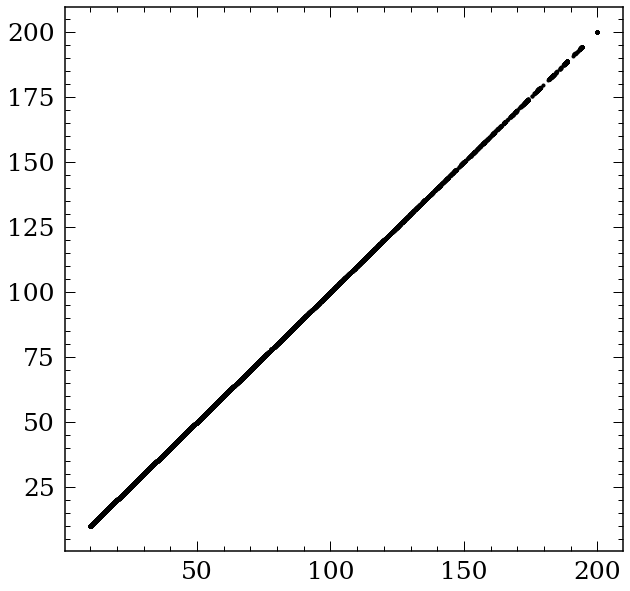

In [709]:
plt.plot(ztf_all_rv_cm.drop_duplicates('gaiaid',keep='first')['Prot'],
        ztf_all_rv_cm.drop_duplicates('gaiaid',keep='last')['Prot'],
        'k.')


In [710]:
ztf_all_rv_cm = ztf_all_rv_cm.drop_duplicates('gaiaid', keep='first').reset_index(drop=True)
len(ztf_all_rv_cm)


56943

In [713]:
ztf_all_rv_cm['abs_G'] = ztf_all_rv_cm['abs_G_dered']

df['abs_G_dered'] = df['abs_G']

In [714]:
df = pd.concat([df[['teff_calc','KIC_x','vz','abs_G_dered','Prot']],
              ztf_all_rv_cm[['teff_calc','gaiaid','vz','abs_G_dered','Prot','KIC_x']]])

df = pd.concat([df, ztf_cheng_gaia_cm[['teff_calc','gaiaid','vz','abs_G','Prot','KIC_x']]])


In [715]:
df['teff_calc'] = np.array(df['teff_calc'], dtype='float')

In [716]:
df['τc'] =[LouisTurnoverTime(i) for i in df['teff_calc']]
df['Ro'] = df['Prot']/df['τc']


In [717]:
df['KID'] = df['KIC_x']
df = df.loc[df['teff_calc']<10000]

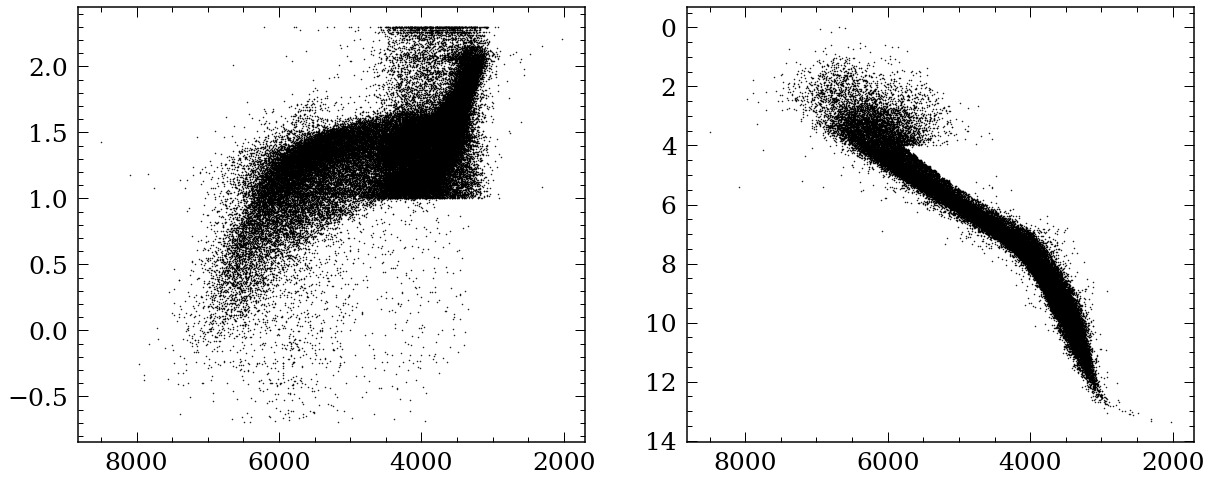

In [892]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['teff_calc'], np.log10(df['Prot']), 'k.', markersize=1)
plt.gca().invert_xaxis()
plt.subplot(1,2,2)
plt.plot(df['teff_calc'], df['abs_G_dered'], 'k.', markersize=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

(14.0, 0.0)

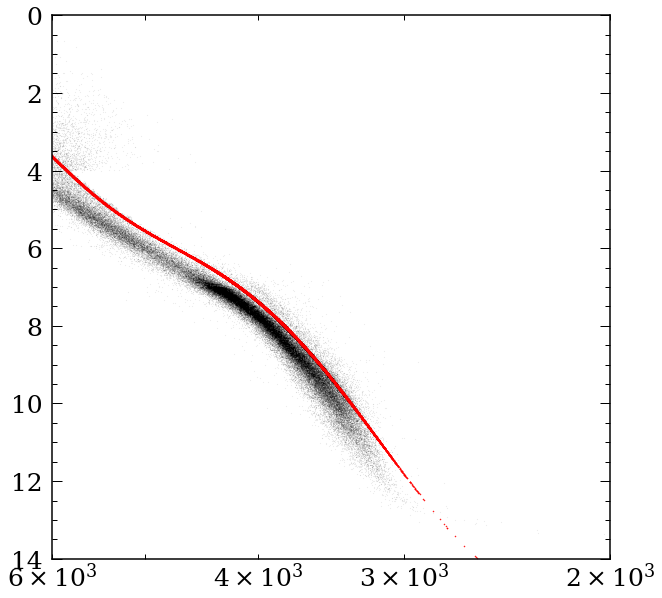

In [893]:
plt.plot(df['teff_calc'], df['abs_G_dered'], 'k.', markersize=0.1, alpha=0.5)
plt.semilogx(df['teff_calc'],p(df['teff_calc'])-0.4,'r.',markersize=1)
plt.xlim([6000,2000])
plt.ylim([14,0])

79840


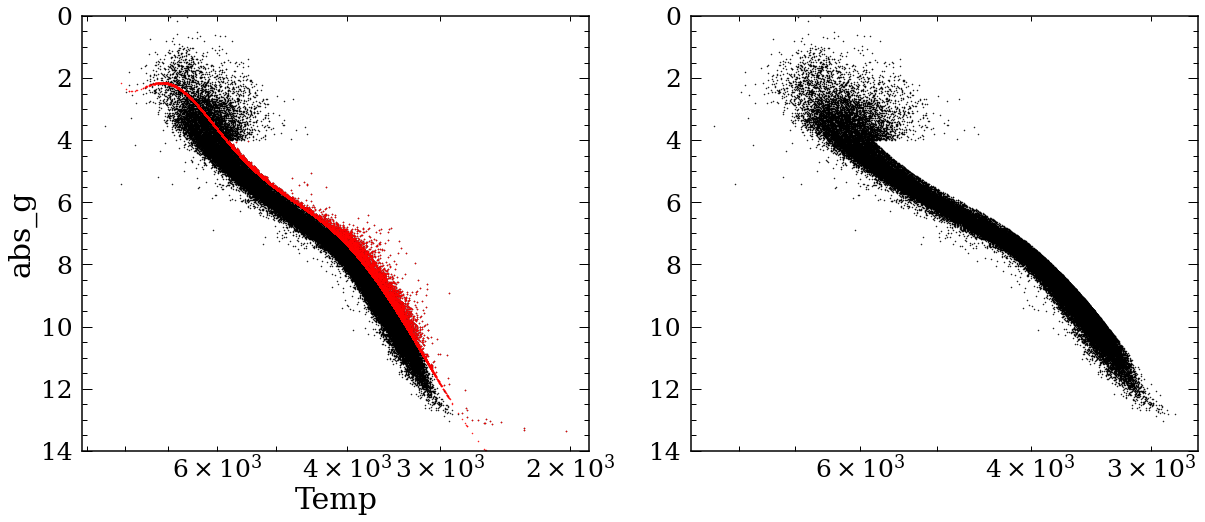

In [894]:
plt.figure(figsize=(20,8))
df = df.dropna(subset=['teff_calc','abs_G_dered'])

plt.subplot(1,2,1)
plt.semilogx(df['teff_calc'],df['abs_G_dered'],'k.',markersize=1)
df = df.sort_values(by='teff_calc').reset_index(drop=True)
p = fitpoints(df['teff_calc'].values,df['abs_G_dered'].values,6)

plt.semilogx(df['teff_calc'],p(df['teff_calc'])-0.4,'r.',markersize=1)

m=df['abs_G_dered']<p(df['teff_calc'])-0.4
m=m&(df['abs_G_dered']>4)

plt.semilogx(df['teff_calc'][m],df['abs_G_dered'][m],'r.',markersize=1)
plt.ylim([0,14])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

plt.subplot(1,2,2)
df_nob = df[~m].reset_index(drop=True)
plt.semilogx(df_nob['teff_calc'],df_nob['abs_G_dered'],'k.',markersize=1)
plt.ylim([0,14])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(len(df_nob))

In [895]:
ASstars = pd.read_csv('ASage.csv')  

ASKICs = ASstars['KIC'].unique()
ASage = np.zeros(len(ASKICs))
ASage_err = np.zeros(len(ASKICs))
for i in range(len(ASKICs)):
    singstar = ASstars.loc[ASstars['KIC']==ASKICs[i]]
    ASage_err[i] = max(singstar['Age'])-min(singstar['Age'])
    ASage[i] = np.mean(singstar['Age'])
ASages = pd.DataFrame(np.array((ASKICs, ASage, ASage_err)).T, columns=['KIC','Age','Age_err'])
ASages = pd.merge(ASages, df_nob, left_on='KIC', right_on='KID', how='inner')
ASages = ASages.loc[ASages['Ro']<2].reset_index(drop=True)

print(len(ASages))

7


In [896]:
M67 = pd.read_csv('m67_subset_wphot.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 3.8*np.ones(len(M67))
M67['Cluster'] = 'M67'
M67['M_G'] = m_to_M(M67['phot_g_mean_mag'], 0.85)
M67['Age_err'] = 0.1

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Age_err'] = oc['AGE_err']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])



In [363]:
oc.Cluster.unique()

array(['Pleiades', 'Praesepe', 'Hyades', 'NGC_6811', 'NGC_752',
       'NGC_6819', 'Ruprecht_147', 'M67'], dtype=object)

In [898]:
#a = pd.merge(gaiadata,M67,left_on='source_id',right_on='source_id',how='inner')
#plt.plot(a['Teff'],a['Prot'],'k.')
#plt.plot(M67['Teff'],M67['Prot'],'r.')

In [899]:
clusterkids = range(len(oc))
clusterteffs = oc['teff_calc'].values
clusterprotlog = np.log10(oc['Prot'].values)
clusterabsg = oc['M_G'].values
τc = [LouisTurnoverTime(i) for i in clusterteffs]
clusterro = oc['Prot'].values/τc
clusterprot = oc['Prot'].values
clustervz = np.zeros(len(oc))
clusterage = oc['Age'].values
clusterage_err = oc['Age_err'].values
clusterdf = pd.DataFrame(np.array((clusterkids,clusterteffs,clusterprotlog,clusterabsg,clusterro,clustervz,clusterage,clusterage_err,clusterprot)).T,
                        columns=['KID','teff_calc','Prot_log','abs_G_dered','Ro','vz','Age','Age_err','Prot'])

clusterdf = clusterdf.loc[clusterdf['Ro']<2].reset_index(drop=True)
#clusterdf = clusterdf.loc[clusterdf['teff_calc']<5000].reset_index(drop=True)
clusterdf = clusterdf.loc[clusterdf['Age']>1].reset_index(drop=True)
df_nob = pd.concat([df_nob, clusterdf])



In [900]:
clusterAS = pd.concat([ASages, clusterdf])
print(len(clusterAS))

150


In [901]:
clusterAS['Prot_log'] = np.log10(clusterAS['Prot'])

In [902]:
#plt.plot(clusterAS['teff_calc'], clusterAS['abs_G_dered'], 'k.')

In [903]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [904]:
df_nob = df_nob[[i for i in df_nob.columns if 'Age' not in i]]

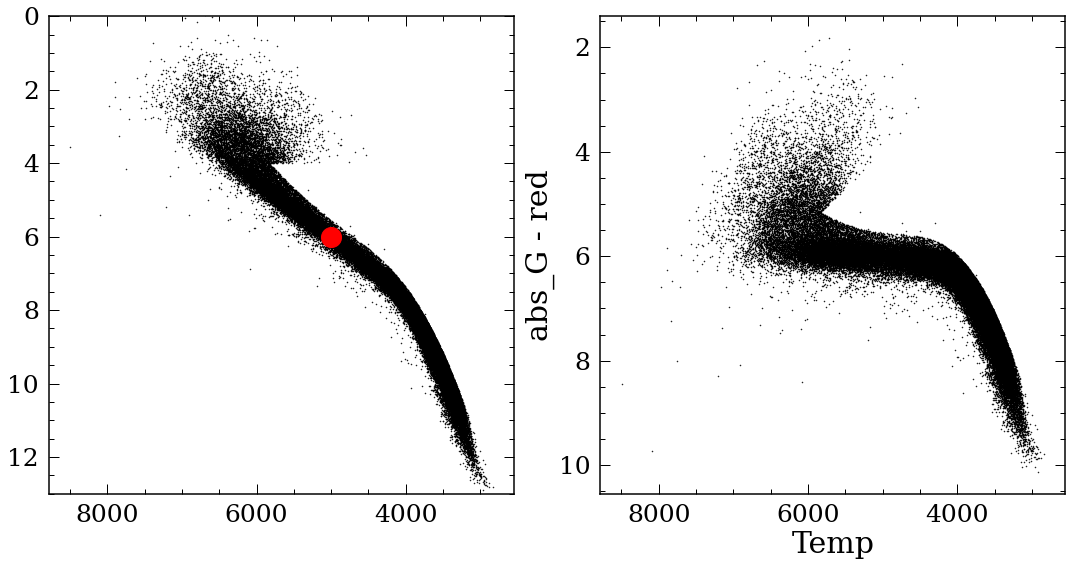

In [905]:
from scipy.ndimage import gaussian_filter
from scipy.spatial.transform import Rotation as R

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'],df_nob['abs_G_dered'],'k.',markersize=1)
#plt.plot(clusterAS['teff_calc'], clusterAS['abs_G'],'ro')

plt.plot([5e3],[6],'ro',markersize=20)

df_nob = df_nob.sort_values(by='teff_calc').reset_index(drop=True)

"""
r = R.from_euler('xyz',(80,80,0), degrees=True) 
p_r=r.apply(np.array([df_nob['teff_calc'].values,df_nob['abs_G'].values,
                      np.zeros(len(df_nob))]).T) #Rotated points
"""

x,y = rotate([5e3,6],[df_nob['teff_calc'].values,df_nob['abs_G_dered'].values],0.0014)

plt.ylim([0,13])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(x,y,'k.',markersize=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

df_nob['abs_G_rot'] = y
df_nob['teff_rot'] = x

plt.xlabel('Temp')
plt.ylabel('abs_G - red')
plt.tight_layout()

In [906]:
x,y = rotate([5e3,6],[clusterAS['teff_calc'].values,clusterAS['abs_G_dered'].values],0.0014)


clusterAS['abs_G_rot'] = y
clusterAS['teff_rot'] = x

#clusterAS

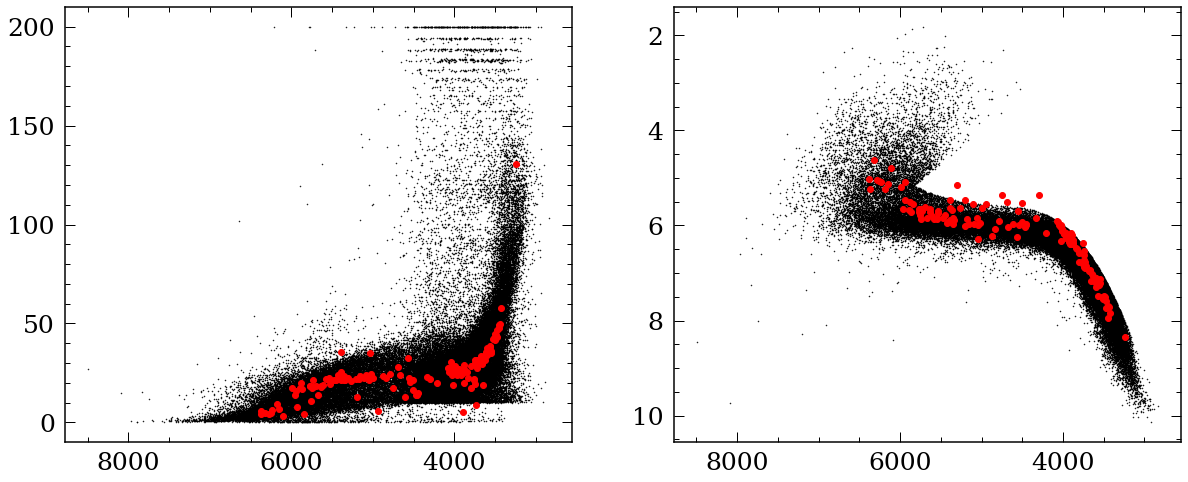

In [907]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'], df_nob['Prot'], 'k.', markersize=1)
plt.plot(clusterAS['teff_calc'], clusterAS['Prot'], 'ro')
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.plot(df_nob['teff_calc'], df_nob['abs_G_rot'], 'k.', markersize=1)
plt.plot(clusterAS['teff_calc'], clusterAS['abs_G_rot'], 'ro')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()



In [908]:
df_nob['Prot_log'] = np.log10(df_nob['Prot'])


In [909]:
df_nob['vz'] = np.array(df_nob['vz'], dtype=float)

In [910]:
clusterAS = clusterAS.reset_index(drop=True)
#len(clusterAS['KID'].unique()), len(clusterAS)

In [911]:
def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    
    fslen=len(fs)
    dflen=len(df_match)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    paras_match=np.zeros((len(df_match),fslen))
    agecomp = df_match[df_match_name].values
    agecomp_err = df_match[df_match_name_err].values
   
            
    for i in range(fslen):
        #print(fs[i], np.shape(df[fs[i]].values), df[fs[i]].values[0])
        paras[:,i]=df[fs[i]].values
        paras_match[:,i]=df_match[fs[i]].values
    
    
    vels=df[vz].values
    kin_age=np.zeros(len(df_match))
    No_stars=np.zeros(len(df_match))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(df_match)):
            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras_match[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras_match[i,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras_match[i,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        
        kinages = v_to_age(kin_age,p_mr)
        m = (kinages!=kinages)
        kinages[m] = -999
        
        if count==0:
            chisq=sum(((agecomp-kinages)**2./np.power(agecomp_err,2.)))/len(df_match)
            age_best=kinages
            opt_binsize=binfs
            count=count+1
        else:
            chisq_new=sum(((agecomp-kinages)**2./np.power(agecomp_err,2.)))/len(df_match)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                age_best=kinages
            count=count+1
        
    return opt_binsize, agecomp, age_best, chisq



In [912]:
df_nob['τc'] = [LouisTurnoverTime(i) for i in df_nob['teff_calc']]
df_nob['Ro'] = df_nob['Prot']/df_nob['τc']

clusterAS['τc'] = [LouisTurnoverTime(i) for i in clusterAS['teff_calc']]
clusterAS['Ro'] = clusterAS['Prot']/clusterAS['τc']


In [913]:
print(len(df_nob))
df_nob = df_nob.loc[df_nob['Ro']<10].reset_index(drop=True)
print(len(df_nob))


79983
79423


In [914]:

clusterAS['Age_0'] = 0.05*clusterAS['Age']


In [934]:

df_nob = df_nob.dropna(subset=['teff_calc','Prot_log','abs_G_rot','Ro']).reset_index(drop=True)

opt_binsize, agecomp, kinages, chisq = optimizeBins(df_nob,clusterAS,['teff_calc','abs_G_rot','Ro'],
                                             [50,0.05,0.05],[200,0.5,0.5],
                                             min_star=10,max_star=50000,df_match_name='Age',
                                             df_match_name_err='Age_err',vz='vz',
                                             bintestNo=50,errVals=False)

df_common = pd.merge(df_common, df_nob[['KID','Ro']], 
                     left_on='KID', right_on='KID', how='inner')
opt_binsize, chisq



  0%|          | 0/125000 [00:00<?, ?it/s]<ipython-input-335-7dc5bf2189af>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 125000/125000 [2:05:59<00:00, 16.54it/s] 
<ipython-input-934-a740144e13b8>:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Ro_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_common = pd.merge(df_common, df_nob[['KID','Ro']],


([157.14285714285714, 0.3346938775510204, 0.42653061224489797],
 52.28666735794807)

Text(0, 0.5, 'Gyro-kinematic Age [Gyr]')

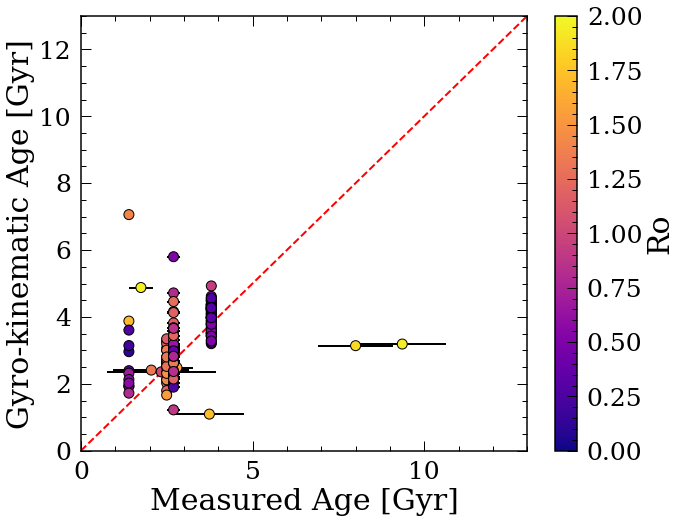

In [943]:


plt.figure(figsize=(10,8))
plt.errorbar(agecomp, kinages, xerr=clusterAS['Age_err'], 
             fmt='k.', markersize=10, zorder=1)

plt.scatter(agecomp, kinages, c=clusterAS['Ro'], 
             cmap='plasma', s=100, zorder=10, edgecolor='k',
           vmin=0, vmax=2)

plt.colorbar(label='Ro')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')




In [936]:
df_nob['vel_dis'],df_nob['kin_age']=getkinAges(df_nob,['teff_calc','abs_G_rot','Ro'],
                                              opt_binsize,vz='vz',min_star=15,
                                               max_star=50000)




100%|██████████| 79423/79423 [00:29<00:00, 2717.07it/s]

4404



<ipython-input-335-7dc5bf2189af>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'M$_G$')

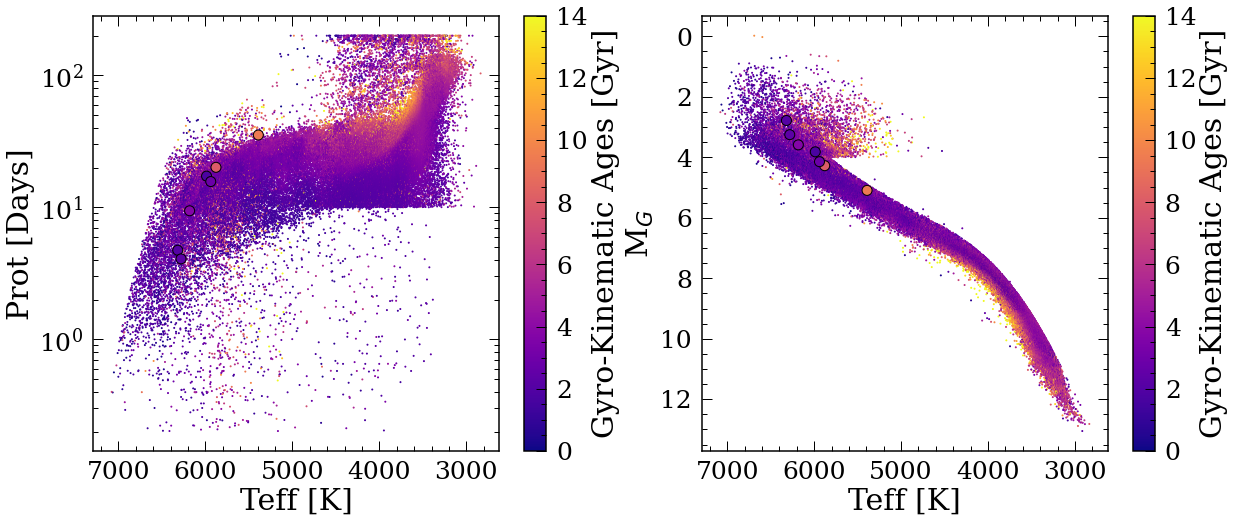

In [937]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],s=1,
            vmin=0,vmax=14,cmap='plasma')
plt.scatter(ASages['teff_calc'], ASages['Prot'], c=ASages['Age'],s=100,edgecolor='k',
           vmin=0,vmax=14,cmap='plasma')
plt.gca().invert_xaxis()
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')

plt.subplot(1,2,2)
plt.scatter(df_nob['teff_calc'], df_nob['abs_G_dered'], c=df_nob['kin_age'],s=1,
           vmin=0,vmax=14,cmap='plasma')
plt.scatter(ASages['teff_calc'], ASages['abs_G_dered'], c=ASages['Age'],s=100,edgecolor='k',
           vmin=0,vmax=14,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')




(10.0, 150.0)

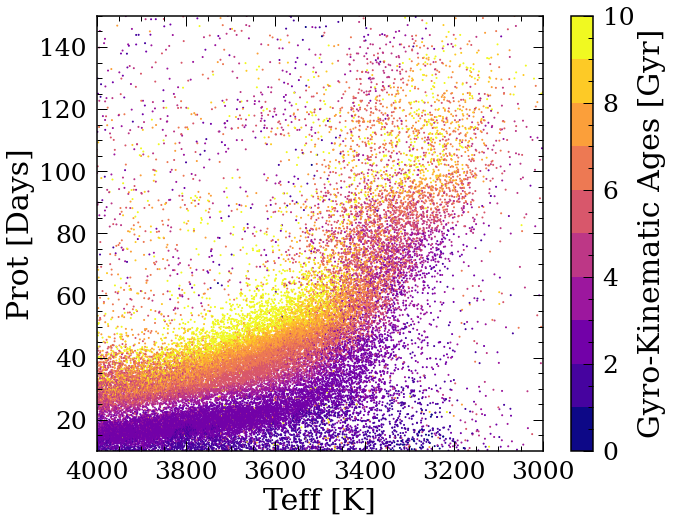

In [10]:
plt.figure(figsize=(10,8))
"""plt.hexbin(df_nob['teff_calc'], df_nob['Prot'], C=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',extent=(3000,4500,np.log10(10),np.log10(150)),
           yscale='log',gridsize=50)"""

plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],
            vmin=0,vmax=10,cmap=plt.get_cmap('plasma', 10),s=1)
"""plt.scatter(ASages['teff_calc'], ASages['Prot'], c=ASages['Age'],s=100,
            edgecolor='k',vmin=0,vmax=10,cmap='plasma')"""
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
#plt.yscale('log')
plt.xlim([4000,3000])
plt.ylim([10,150])
#plt.vlines(3450,ymax=150,ymin=10,color='r')
#plt.vlines(3400,ymax=150,ymin=10,color='r')



In [11]:
fullyconvective = df_nob.loc[(df_nob['teff_calc']>3350)&(df_nob['teff_calc']<3400)]
gap = df_nob.loc[(df_nob['teff_calc']>3800)&(df_nob['teff_calc']<3850)]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


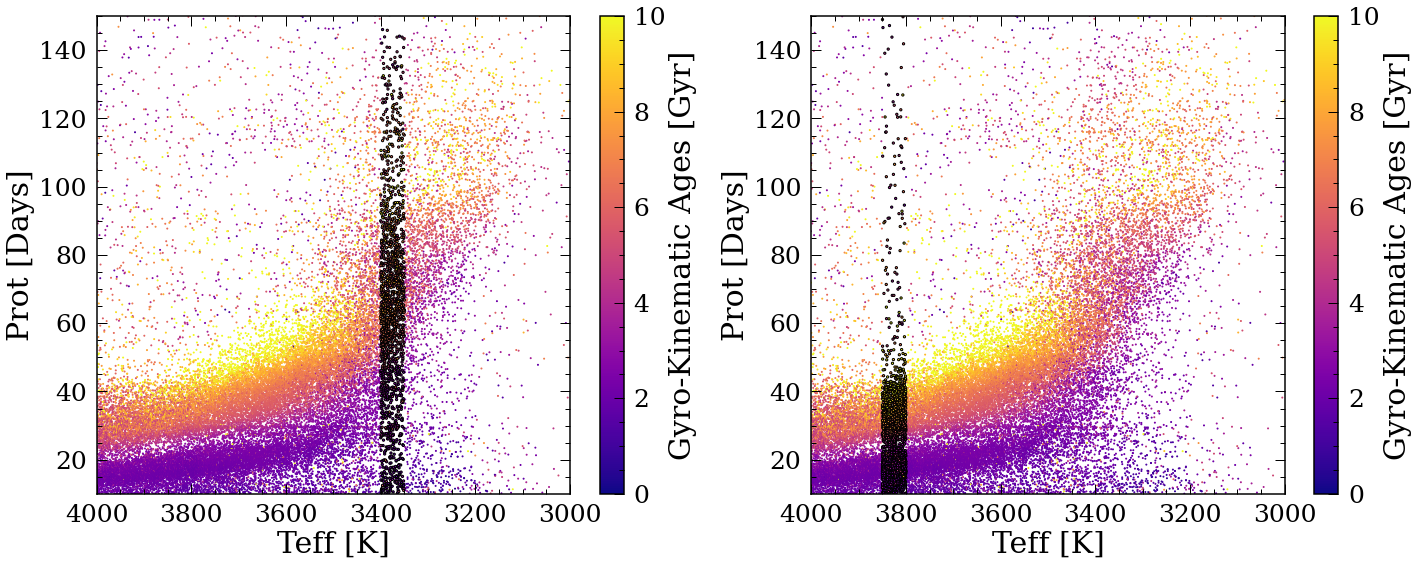

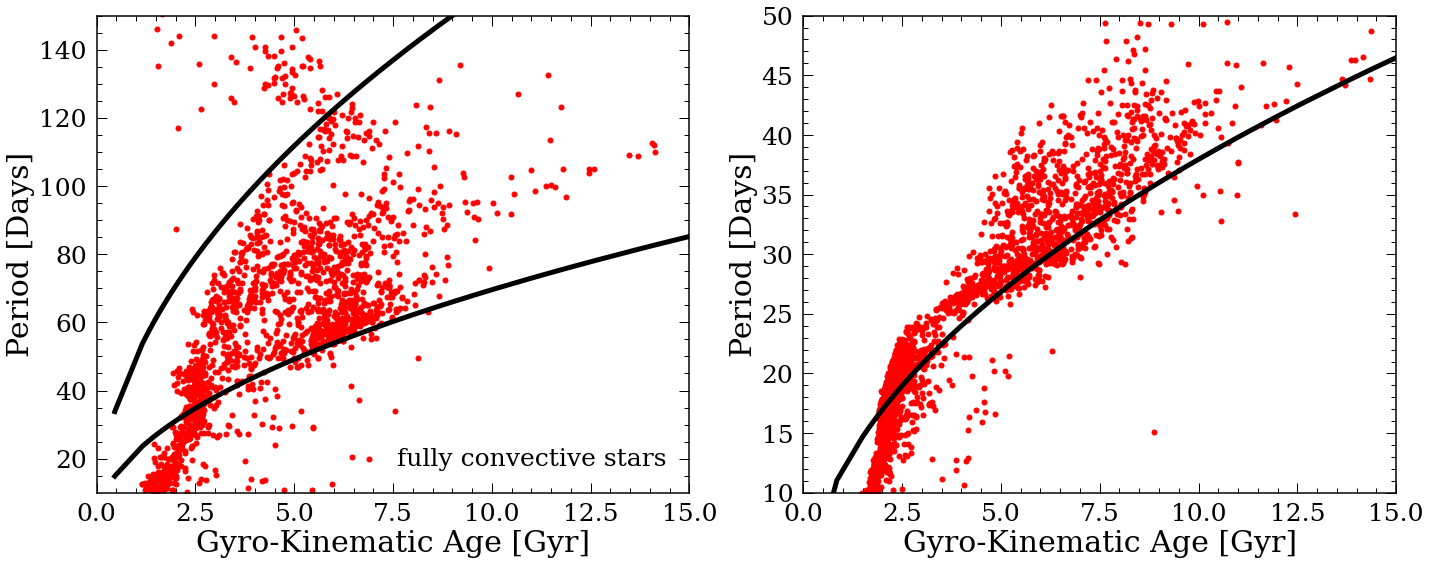

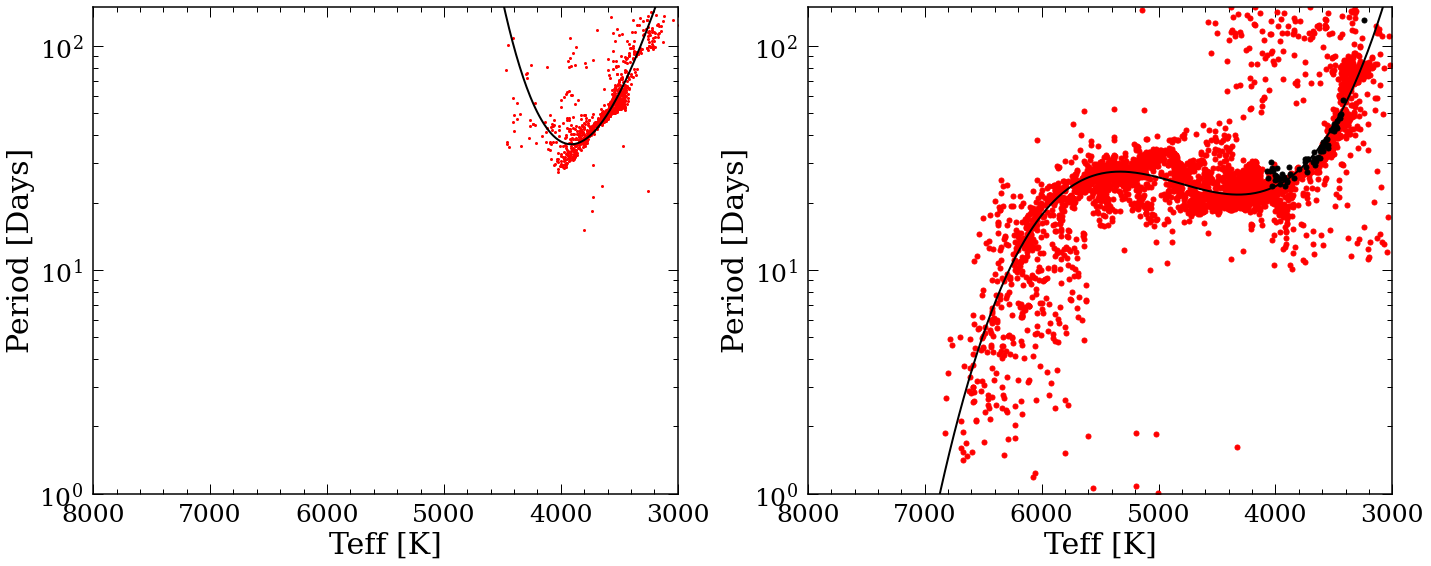

In [204]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',s=1)
plt.scatter(fullyconvective['teff_calc'], fullyconvective['Prot'], c=fullyconvective['kin_age'],
            vmin=0,vmax=10,cmap='plasma',s=5, edgecolor='k')
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
#plt.yscale('log')
plt.xlim([4000,3000])
plt.ylim([10,150])

plt.subplot(1,2,2)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',s=1)
plt.scatter(gap['teff_calc'], gap['Prot'], c=gap['kin_age'],
            vmin=0,vmax=10,cmap='plasma',s=5, edgecolor='k')
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
#plt.yscale('log')
plt.xlim([4000,3000])
plt.ylim([10,150])
plt.tight_layout()


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(fullyconvective['kin_age'],fullyconvective['Prot'],'ro',
         label='fully convective stars',markersize=5)
fullyconvective = fullyconvective.sort_values('kin_age')
plt.plot(fullyconvective['kin_age'], fullyconvective['kin_age']**0.5*22,
        'k-',linewidth=5)
plt.plot(fullyconvective['kin_age'], fullyconvective['kin_age']**0.5*50,
        'k-',linewidth=5)

plt.xlim([0,15])
plt.ylim([10,150])
#plt.yscale('log')
plt.legend()
plt.xlabel('Gyro-Kinematic Age [Gyr]')
plt.ylabel('Period [Days]')

plt.subplot(1,2,2)
plt.plot(gap['kin_age'],gap['Prot'],'ro',markersize=5)
gap = gap.sort_values('kin_age')
plt.plot(gap['kin_age'], gap['kin_age']**0.5*12,'k-',linewidth=5)
plt.xlim([0,15])
plt.ylim([10,50])
#plt.yscale('log')
plt.legend()
plt.xlabel('Gyro-Kinematic Age [Gyr]')
plt.ylabel('Period [Days]')
plt.tight_layout()

M67 = pd.read_csv('m67_subset_wphot.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 3.8*np.ones(len(M67))
M67['Cluster'] = 'M67'
M67['M_G'] = m_to_M(M67['phot_g_mean_mag'], 0.85)
M67['Age_err'] = 0.1



plt.figure(figsize=(20,8))
plt.subplot(1,2,2)
m = (df_nob['kin_age']>3.6)&(df_nob['kin_age']<4)
plt.plot(df_nob['teff_calc'][m],df_nob['Prot'][m],'ro',markersize=5)

#p = fitpoints(df_nob['teff_calc'][m],df_nob['Prot'][m], 6)
#plt.plot(np.linspace(3000,8000,500), p(np.linspace(3000,8000,500)), 'k-')

#################### get rid of outliers ####################
df_nob_gau = df_nob[m]
df_nob_gau = df_nob_gau.sort_values(by='teff_calc').reset_index(drop=True)
teff, rots = movingMed_time(df_nob_gau['teff_calc'].values, 
                            df_nob_gau['Prot'].values, 100, 200)
#plt.plot(teff,rots, 'k-')
from scipy import interpolate
int1dout = interpolate.interp1d(np.append([df_nob_gau['teff_calc'].values[0],
                                           df_nob_gau['teff_calc'].values[-1]],teff),
                                np.append([df_nob_gau['Prot'].values[0],
                                           df_nob_gau['Prot'].values[-1]],rots))

m = (df_nob_gau['teff_calc']>5000)|(abs(df_nob_gau['Prot']-int1dout(df_nob_gau['teff_calc']))/(0.1*df_nob_gau['Prot'])<5)
df_nob_gau = df_nob_gau[m].reset_index(drop=True)

#plt.plot(df_nob_gau['teff_calc'], df_nob_gau['Prot'], 'ko')
#plt.plot(teff,rots, 'k-')
#################### get rid of outliers ####################

#################### fit lines ####################
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(3),
                      RANSACRegressor(loss='squared_error'))
x_train = df_nob_gau['teff_calc'].values[:, np.newaxis]
y_train = np.log(df_nob_gau['Prot'].values)
model.fit(x_train, y_train)

test_x = np.linspace(3000,8000,500).reshape(-1, 1)
predictions = model.predict(test_x)
plt.plot(test_x, np.exp(predictions), 'k-')


#from scipy.signal import savgol_filter
#xhat, yhat = savgol_filter((x_train[:,0], np.exp(y_train)), 501, 3) # window size 51, polynomial order 3
#plt.plot(xhat, yhat, 'k-')
#################### fit lines ####################

plt.plot(M67['teff_calc'], M67['Prot'],'ko',markersize=5)
plt.xlim([8000,3000])
plt.ylim([1,150])
plt.yscale('log')
plt.xlabel('Teff [K]')
plt.ylabel('Period [Days]')




plt.subplot(1,2,1)
m = (df_nob['kin_age']>8.5)&(df_nob['kin_age']<9)&(df_nob['teff_calc']<4500)
plt.plot(df_nob['teff_calc'][m],df_nob['Prot'][m],'ro',markersize=2)

df_nob_gau = df_nob[m].reset_index(drop=True)
x_train = df_nob_gau['teff_calc'].values[:, np.newaxis]
y_train = np.log(df_nob_gau['Prot'].values)
model.fit(x_train, y_train)

test_x = np.linspace(3000,8000,500).reshape(-1, 1)
predictions = model.predict(test_x)
plt.plot(test_x, np.exp(predictions), 'k-')


plt.xlim([8000,3000])
plt.ylim([1,150])
plt.yscale('log')
plt.xlabel('Teff [K]')
plt.ylabel('Period [Days]')
plt.tight_layout()

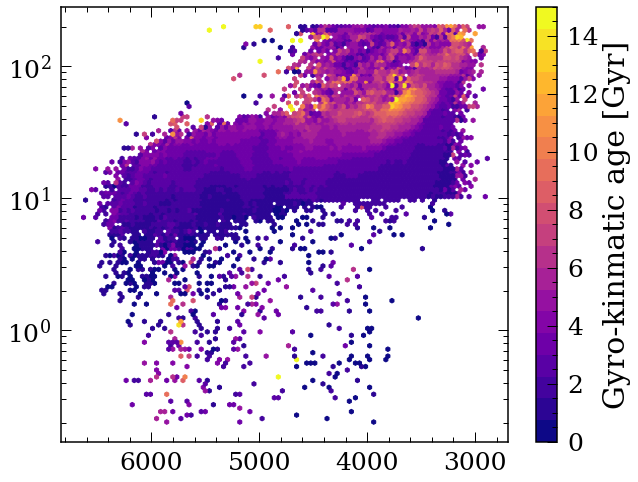

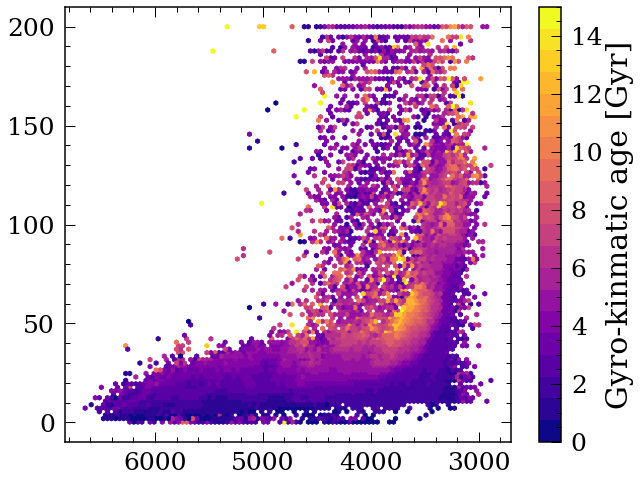

In [241]:
m = (df_nob['abs_G']>4)
df_nob = df_nob[m].reset_index(drop=True)
plt.figure(figsize=(10,8))
plt.hexbin(df_nob['teff_calc'][m], df_nob['Prot'][m], C=df_nob['kin_age'][m],
          vmin=0,vmax=15, yscale='log', reduce_C_function=np.median,
          cmap=plt.get_cmap('plasma',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Gyro-kinmatic age [Gyr]')


plt.figure(figsize=(10,8))
plt.hexbin(df_nob['teff_calc'][m], df_nob['Prot'][m], C=df_nob['kin_age'][m],
          vmin=0,vmax=15, reduce_C_function=np.median,
          cmap=plt.get_cmap('plasma',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Gyro-kinmatic age [Gyr]')

In [253]:
len(df_nob)

75517

/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in doubl

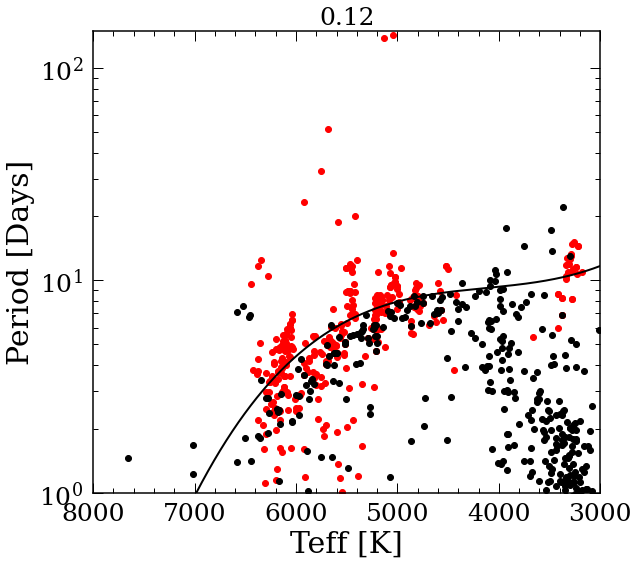

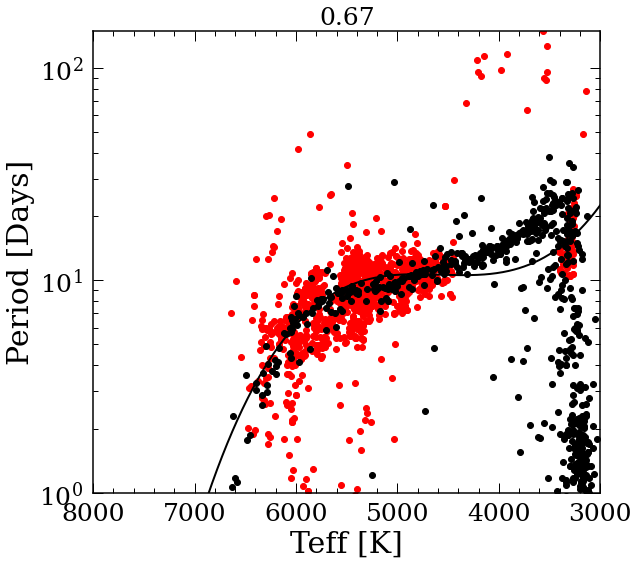

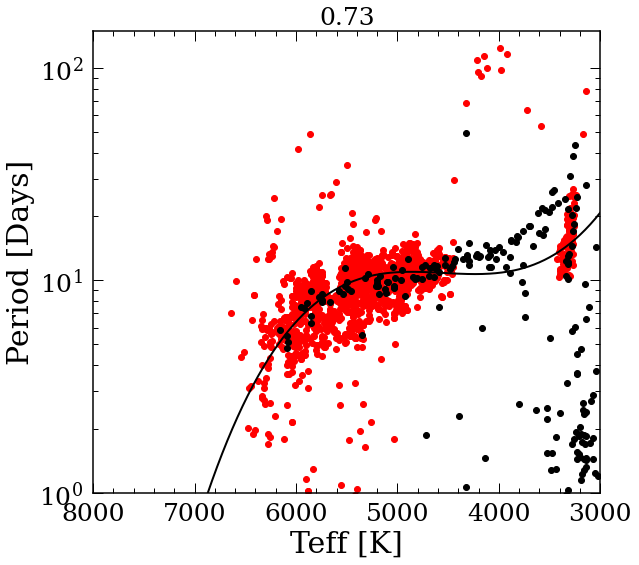

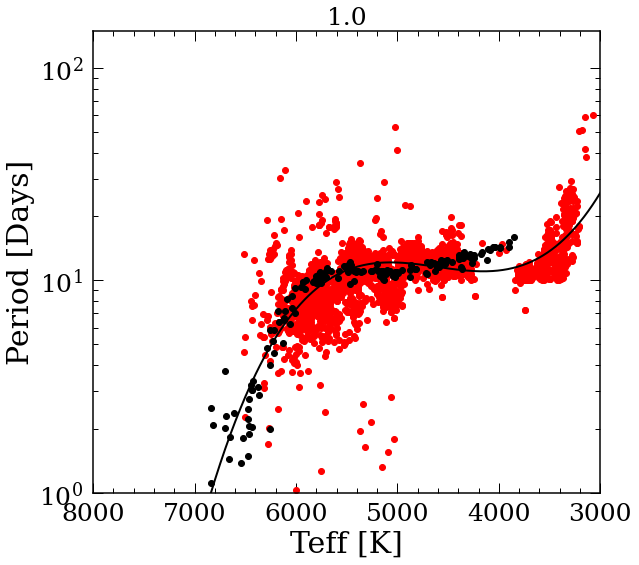

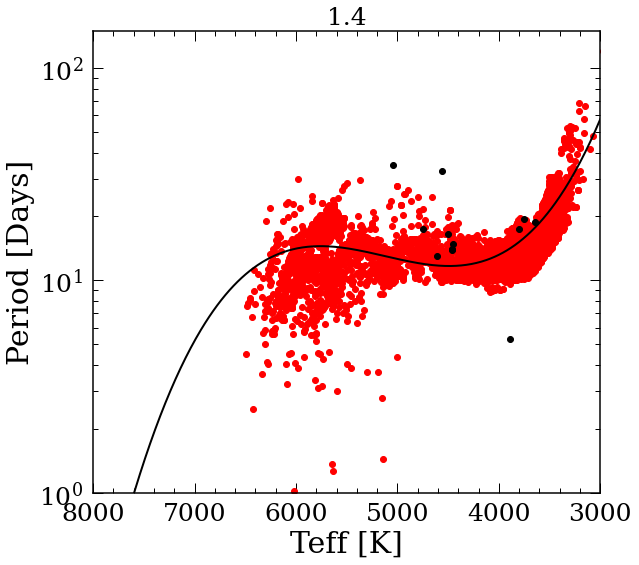

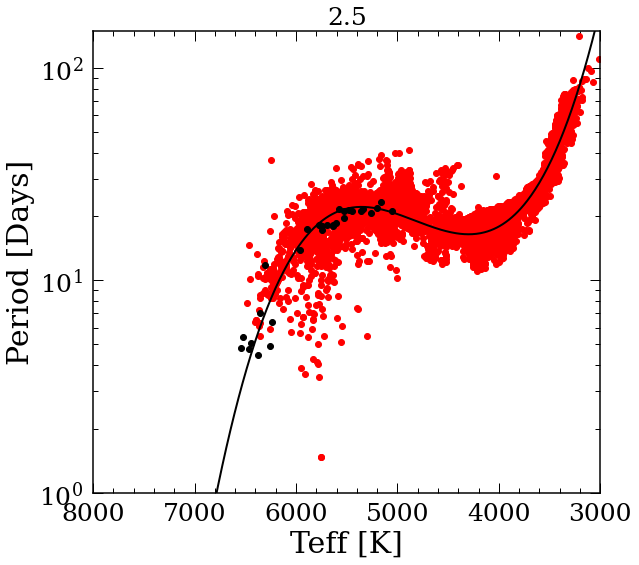

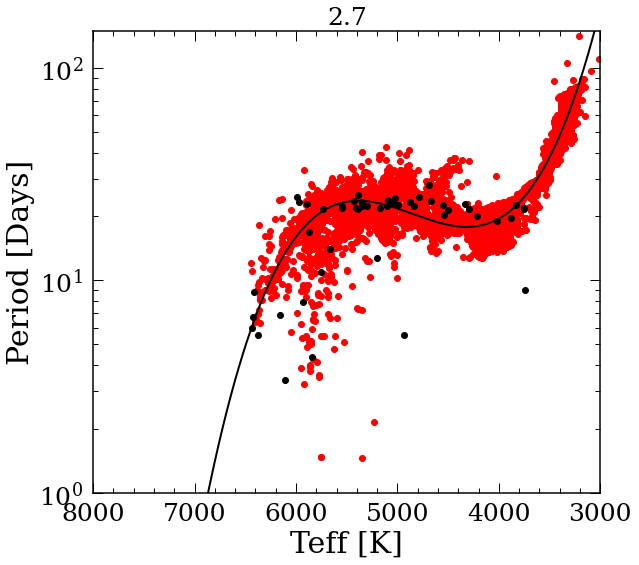

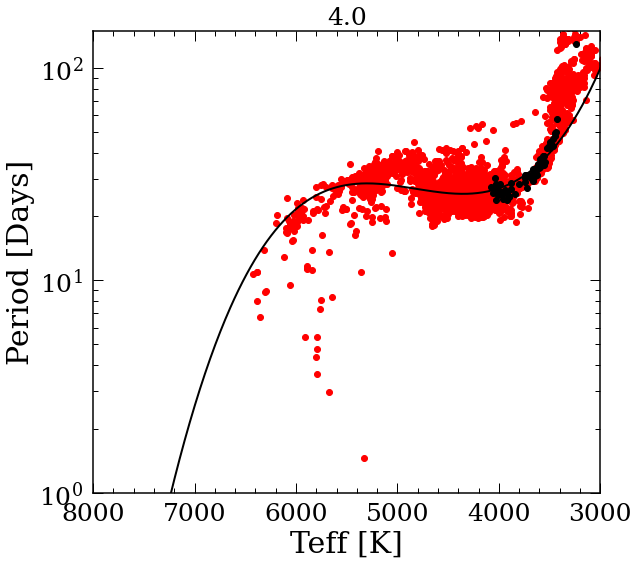

In [252]:
M67 = pd.read_csv('m67_analysis_subset.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 4*np.ones(len(M67))
M67['Cluster'] = 'M67'

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67]).reset_index(drop=True)

uniqclust = oc['Cluster'].unique()
for i in range(len(uniqclust)):
    clus_sing = oc[oc['Cluster']==uniqclust[i]]
    m = (df_nob['kin_age']>clus_sing['Age'].values[0]+0.5-0.2)&(df_nob['kin_age']<clus_sing['Age'].values[0]+0.5+0.2)
    #################### get rid of outliers ####################
    df_nob_gau = df_nob[m]
    plt.figure(figsize=(9,8))
    
    #plt.plot(df_nob_gau['teff_calc'],df_nob_gau['Prot'],'ro', markersize=5)
    
    df_nob_gau = df_nob_gau.sort_values(by='teff_calc').reset_index(drop=True)
    teff, rots = movingMed_time(df_nob_gau['teff_calc'].values, 
                                df_nob_gau['Prot'].values, 100, 200)
    #plt.plot(teff,rots, 'k-')
    from scipy import interpolate
    int1dout = interpolate.interp1d(np.append([df_nob_gau['teff_calc'].values[0],
                                               df_nob_gau['teff_calc'].values[-1]],teff),
                                    np.append([df_nob_gau['Prot'].values[0],
                                               df_nob_gau['Prot'].values[-1]],rots))

    m = (df_nob_gau['teff_calc']>5000)|(abs(df_nob_gau['Prot']-int1dout(df_nob_gau['teff_calc']))/(0.1*df_nob_gau['Prot'])<5)
    df_nob_gau = df_nob_gau[m].reset_index(drop=True)

    plt.plot(df_nob_gau['teff_calc'], df_nob_gau['Prot'], 'ro')
    teff, rots = movingMed_time(df_nob_gau['teff_calc'].values, 
                                df_nob_gau['Prot'].values, 300, 100)
    #plt.plot(teff,rots, 'k-')
    #################### get rid of outliers ####################

    #################### fit lines ####################
    model = make_pipeline(PolynomialFeatures(3),
                          RANSACRegressor(loss='squared_error'))
    x_train = df_nob_gau['teff_calc'].values[:, np.newaxis]
    y_train = np.log(df_nob_gau['Prot'].values)
    model.fit(x_train, y_train)

    test_x = np.linspace(3000,8000,500).reshape(-1, 1)
    predictions = model.predict(test_x)
    plt.plot(test_x, np.exp(predictions), 'k-')
    plt.plot(clus_sing['teff_calc'], clus_sing['Prot'], 'ko')
    plt.xlim([8000,3000])
    plt.ylim([1,150])
    plt.yscale('log')
    plt.xlabel('Teff [K]')
    plt.ylabel('Period [Days]')
    plt.title(str(clus_sing['Age'].values[0]), fontsize=25)
    plt.tight_layout()


In [282]:
agebin = np.linspace(0,15,35)
mall = np.ones(len(df_nob), dtype=bool)
df_nob = df_nob.sort_values(by='teff_calc').reset_index(drop=True)
for i in range(len(agebin)-1):
    m = (df_nob['kin_age']>agebin[i])&(df_nob['kin_age']<agebin[i+1])
    if sum(m)<100:
        continue
    #################### get rid of outliers ####################
    df_nob_gau = df_nob[m]
    teff, rots = movingMed_time(df_nob_gau['teff_calc'].values, 
                                df_nob_gau['Prot'].values, 100, 200)
    int1dout = interpolate.interp1d(np.append([df_nob_gau['teff_calc'].values[0],
                                               df_nob_gau['teff_calc'].values[-1]],teff),
                                    np.append([df_nob_gau['Prot'].values[0],
                                               df_nob_gau['Prot'].values[-1]],rots))

    m2 = (df_nob_gau['teff_calc']>5000)|(abs(df_nob_gau['Prot']-int1dout(df_nob_gau['teff_calc']))/(0.1*df_nob_gau['Prot'])<5)
    
    """plt.figure(figsize=(10,8))
    plt.plot(df_nob_gau['teff_calc'], df_nob_gau['Prot'], 'ko')
    plt.plot(df_nob_gau['teff_calc'][m2], df_nob_gau['Prot'][m2], 'ro')
    plt.gca().invert_xaxis()
    plt.yscale('log')"""
    mall[m] = m2
    

/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.12
0.67
0.73
1.0
1.4
2.5
2.7
4.0


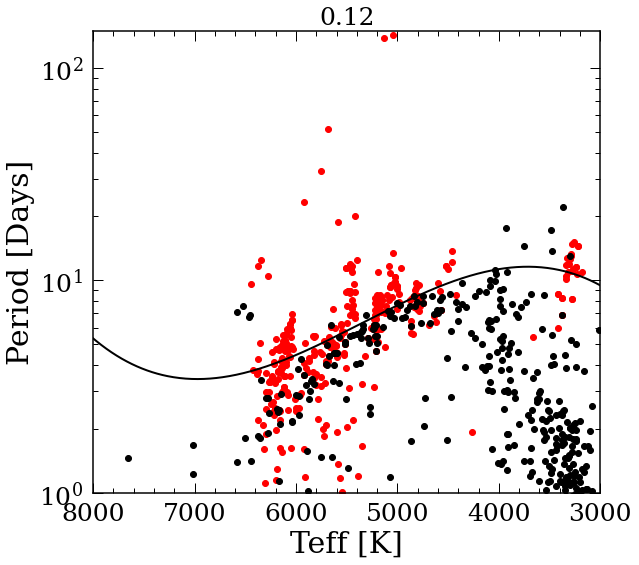

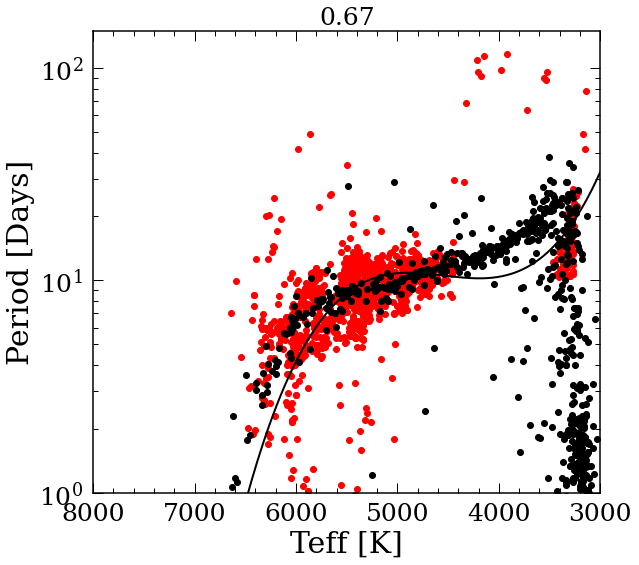

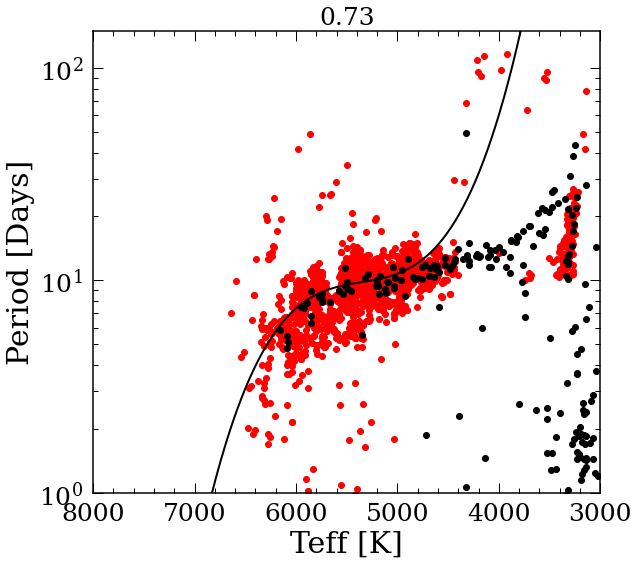

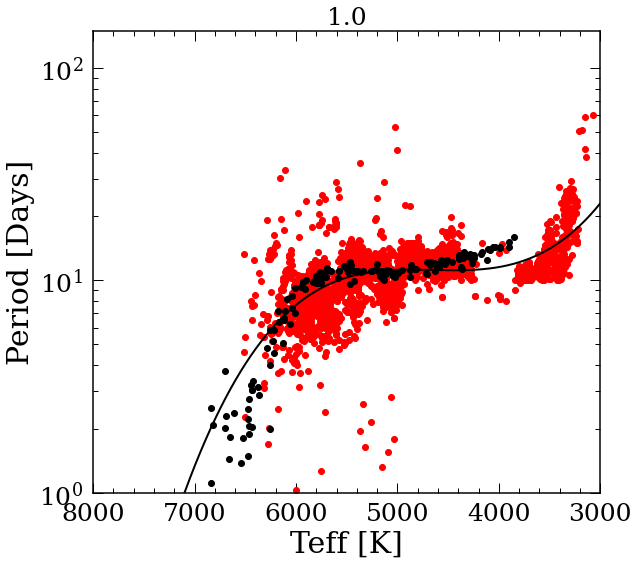

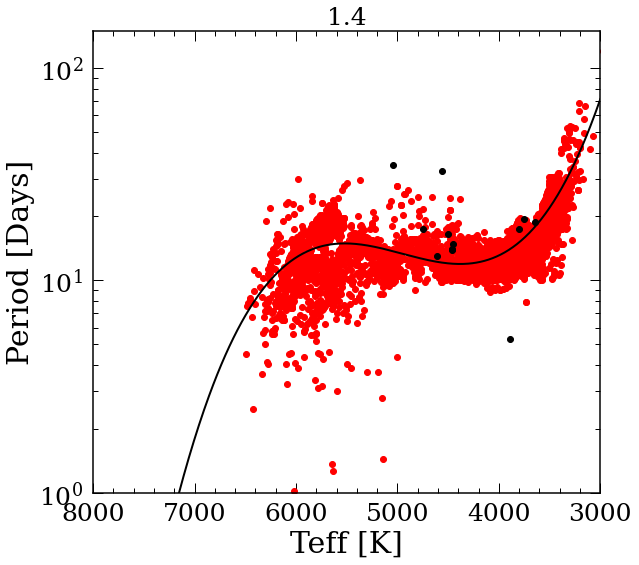

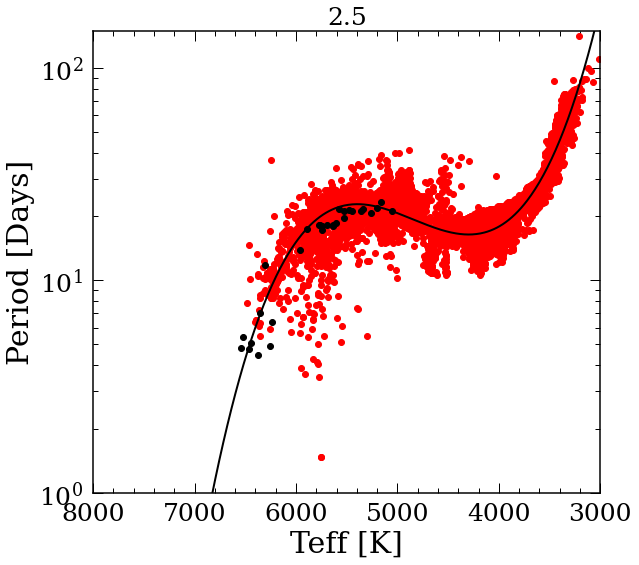

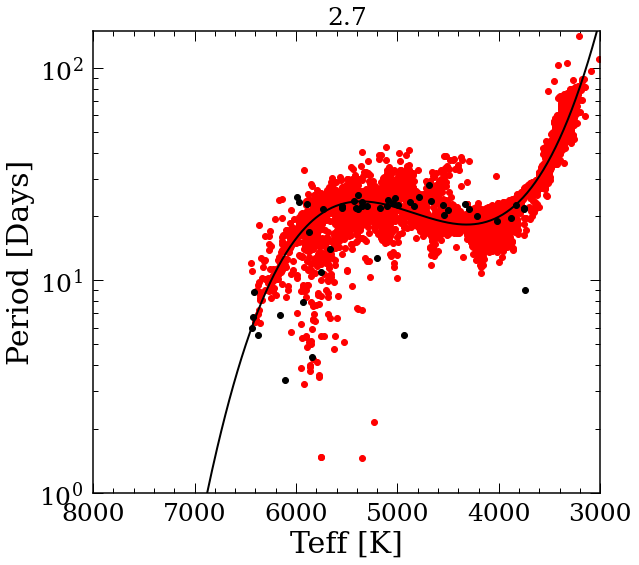

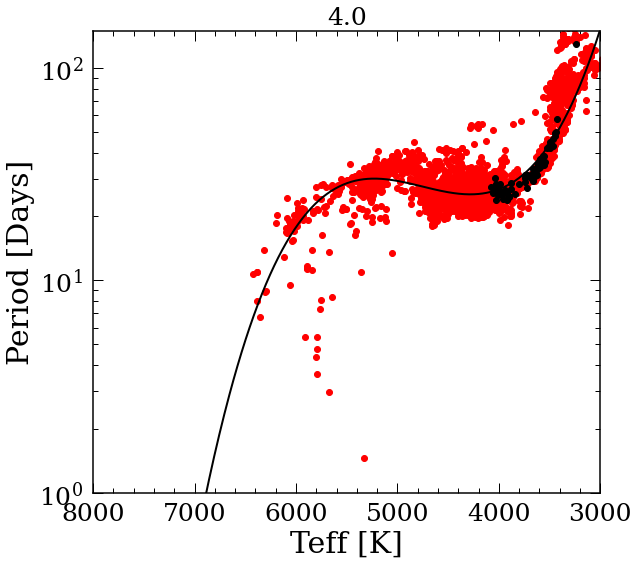

In [313]:
#df_nob = df_nob[mall].reset_index(drop=True)
for i in range(len(uniqclust)):
    clus_sing = oc[oc['Cluster']==uniqclust[i]]
    print(clus_sing['Age'].values[0])
    m = (df_nob['kin_age']>clus_sing['Age'].values[0]+0.5-0.2)&(df_nob['kin_age']<clus_sing['Age'].values[0]+0.5+0.2)
    df_nob_gau = df_nob[m]
    plt.figure(figsize=(9,8))
    plt.plot(df_nob_gau['teff_calc'], df_nob_gau['Prot'], 'ro')

    #################### fit lines ####################
    model = make_pipeline(PolynomialFeatures(3),
                          RANSACRegressor(loss='squared_error'))
    x_train = df_nob_gau['teff_calc'].values[:, np.newaxis]
    y_train = np.log(df_nob_gau['Prot'].values)
    model.fit(x_train, y_train)

    test_x = np.linspace(3000,8000,500).reshape(-1, 1)
    predictions = model.predict(test_x)
    plt.plot(test_x, np.exp(predictions), 'k-')
    plt.plot(clus_sing['teff_calc'], clus_sing['Prot'], 'ko')
    plt.xlim([8000,3000])
    plt.ylim([1,150])
    plt.yscale('log')
    plt.xlabel('Teff [K]')
    plt.ylabel('Period [Days]')
    plt.title(str(clus_sing['Age'].values[0]), fontsize=25)
    plt.tight_layout()

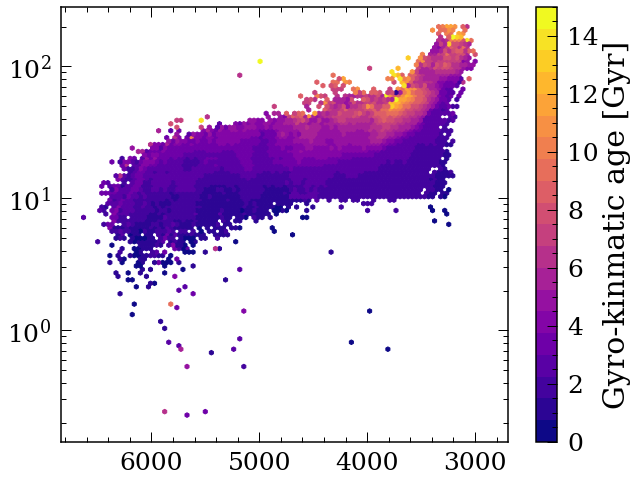

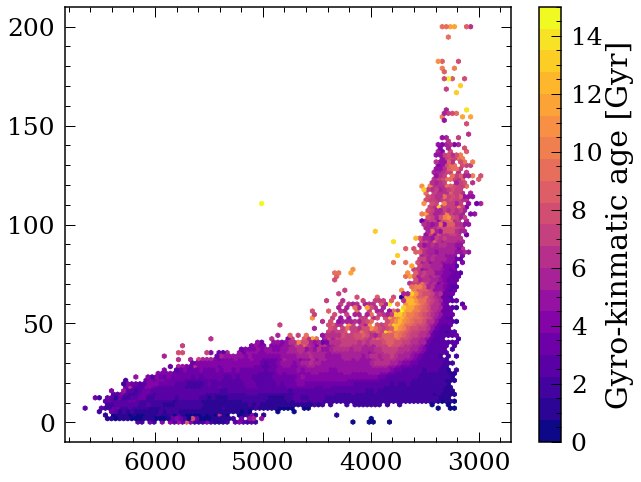

In [284]:

plt.figure(figsize=(10,8))
plt.hexbin(df_nob['teff_calc'], df_nob['Prot'], C=df_nob['kin_age'],
          vmin=0,vmax=15, yscale='log', reduce_C_function=np.median,
          cmap=plt.get_cmap('plasma',20),mincnt=1)
plt.gca().invert_xaxis()
plt.colorbar(label='Gyro-kinmatic age [Gyr]')


plt.figure(figsize=(10,8))
plt.hexbin(df_nob['teff_calc'], df_nob['Prot'], C=df_nob['kin_age'],
          vmin=0,vmax=15, reduce_C_function=np.median,
          cmap=plt.get_cmap('plasma',20),mincnt=1)
plt.gca().invert_xaxis()
plt.colorbar(label='Gyro-kinmatic age [Gyr]')

#df_nob[mall].to_csv('AllztfAge.csv', index=False)

Text(0, 0.5, 'M$_G$')

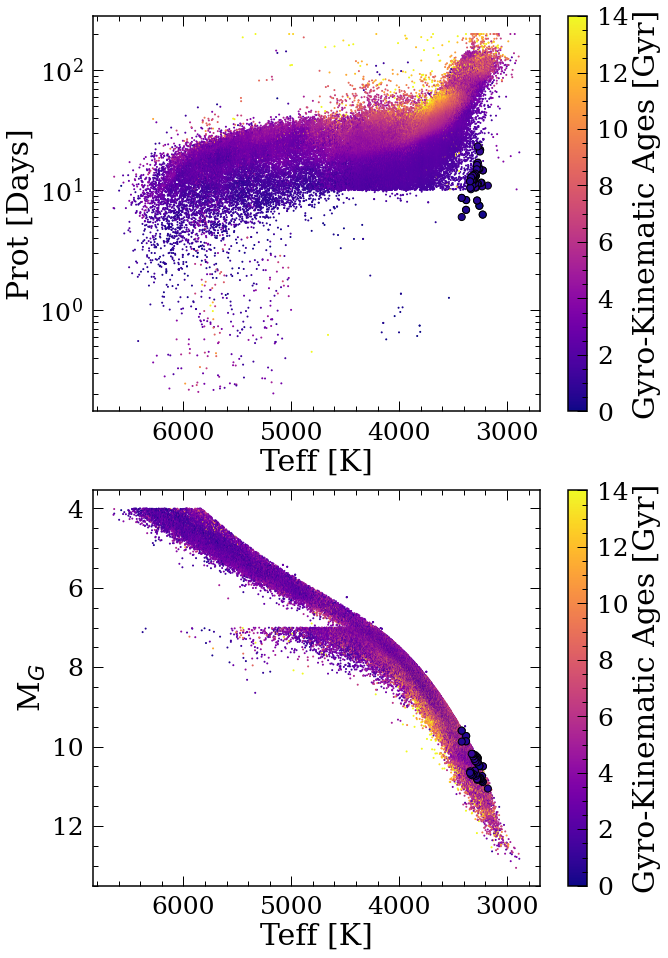

In [357]:
m = df_nob['teff_calc']<3500
m = m&(df_nob['kin_age']<1)

plt.figure(figsize=(10,16))
plt.subplot(2,1,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],s=1,
            vmin=0,vmax=14,cmap='plasma')
plt.scatter(df_nob['teff_calc'][m], df_nob['Prot'][m], c=df_nob['kin_age'][m],s=50,
            vmin=0,vmax=14,cmap='plasma',edgecolor='k')
plt.gca().invert_xaxis()
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')

plt.subplot(2,1,2)
plt.scatter(df_nob['teff_calc'], df_nob['abs_G'], c=df_nob['kin_age'],s=1,
           vmin=0,vmax=14,cmap='plasma')
plt.scatter(df_nob['teff_calc'][m], df_nob['abs_G'][m], c=df_nob['kin_age'][m],s=50,
            vmin=0,vmax=14,cmap='plasma',edgecolor='k')


plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')





# combine with clusters

In [356]:
#df_nob = pd.read_pickle('new_age_ztf.pkl')

#df_nob = pd.read_pickle('new_age_ztf_twosame.pkl')

df_nob = pd.read_csv('AllztfAge.csv')

In [358]:
M67 = pd.read_csv('m67_analysis_subset.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 4*np.ones(len(M67))
M67['Cluster'] = 'M67'

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])

df_bin = df_nob

In [359]:
oc.columns

Index(['CLUSTER', 'DR2NAME', 'DR2_NUM', 'ID', 'ID_SOURCE', 'RA', 'DEC',
       'BP_RP', 'GMAG', 'AGE', 'AV', 'PLX', 'DISTANCE', 'DM', 'BP_RP_0', 'M_G',
       'BINARY_SHORT', 'BINARY_WIDE', 'PROT', 'E_PROT', 'PROT_REF', 'TEFF',
       'MASS', 'BENCH', 'KID', 'AGE_err', 'teff_calc', 'Prot', 'Age',
       'Cluster', 'source_id', 'ps1_id', 'Teff', 'fap'],
      dtype='object')

In [360]:
from scipy import interpolate
 
    
msltteffs = [5000,6000,7000,11000]
mslt = np.array([3e10,1e10,2e9,2e8])/1e9
msteff = interpolate.interp1d(mslt,msltteffs,kind='linear')



In [362]:

agebins = np.append([0.67, 1, 1.4, 2.5, 2.7, 3.8], np.linspace(0.5,14,50))
agebins = sorted(agebins)
count = 0

ac = getcolor(agebins,plt.cm.get_cmap('plasma'))
for i in trange(len(agebins)):
    minage = agebins[i]
    
    if minage<3:
        mincountno = 4
    elif minage<4:
        mincountno = 2
    else:
        mincountno = 1
    
    df_agebin = df_bin.loc[(df_bin['kin_age']>minage+0.5-0.2)&(df_bin['kin_age']<minage+0.5+0.2)]
    
    plt.figure(figsize=(10,8))
    plt.hexbin(df_bin['teff_calc'],df_bin['Prot'],C=df_bin['kin_age'],
               extent=(3000, 7000,1,np.log10(200)), gridsize=100 ,mincnt=1,
               vmin=0,vmax=14, alpha=0.4,yscale='log',
               cmap=plt.cm.get_cmap('plasma'))
    
    #plt.plot(df_agebin['teff_calc'], df_agebin['Prot'], 'ro')

    
    model = make_pipeline(PolynomialFeatures(3),
                          RANSACRegressor(loss='squared_error'))
    x_train = df_agebin['teff_calc'].values[:, np.newaxis]
    y_train = np.log(df_agebin['Prot'].values)
    model.fit(x_train, y_train)

    msltcut = msteff(minage)
    #print(msltcut)
    if minage>3:
        test_x = np.linspace(min(df_agebin['teff_calc']),
                         np.percentile(df_agebin['teff_calc'],90),100).reshape(-1, 1)
        predictions = model.predict(test_x)
        plt.plot(test_x[:,0], np.exp(predictions),'-',linewidth=5,color=ac[i])
    elif minage<1:
        test_x = np.linspace(4000,6000,100).reshape(-1, 1)
        predictions = model.predict(test_x)
        plt.plot(test_x[:,0], np.exp(predictions),'-',linewidth=5,color=ac[i])
    elif minage<2:
        test_x = np.linspace(min(df_agebin['teff_calc']),6000,100).reshape(-1, 1)
        predictions = model.predict(test_x)
        plt.plot(test_x[:,0], np.exp(predictions),'-',linewidth=5,color=ac[i])
    else:
        test_x = np.linspace(min(df_agebin['teff_calc']),7000,100).reshape(-1, 1)
        predictions = model.predict(test_x)
        plt.plot(test_x[:,0], np.exp(predictions),'-',linewidth=5,color=ac[i])
        
    
    
    if minage==0.67:
        m = oc['Cluster']=='Praesepe'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif minage==1:
        m = oc['Cluster']=='NGC_6811'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif minage==1.4:
        m = oc['Cluster']=='NGC_752'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif minage==2.5:
        m = oc['Cluster']=='NGC_6819'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif minage==2.7:
        m = oc['Cluster']=='Ruprecht_147'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif minage==3.8:
        m = oc['Cluster']=='M67'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    else:
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,edgecolor='k')


    

    plt.ylim([1,200])
    plt.xlim([7000, 3000])
    plt.ylabel('Prot [Days]')
    plt.xlabel('$T_{eff}$ [K]')
    #plt.gca().invert_xaxis()
    cb = plt.colorbar()
    cb.set_label('Gyro-kinematic age [Gyr]')
    
    if minage==0.67:
        for j in range(10):
            plt.text(6000,50,'Praesepe\n 0.67 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif minage==1:
        for j in range(10):
            plt.text(6000,50,'NGC 6811\n 1 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif minage==1.4:
        for j in range(10):
            plt.text(6000,50,'NGC 752\n 1.4 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif minage==2.5:
        for j in range(10):
            plt.text(6000,50,'NGC 6819\n 2.5 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1        
    elif minage==2.7:
        for j in range(10):
            plt.text(6000,50,'Ruprecht 147\n 2.7 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif minage==3.8:
        for j in range(10):
            plt.text(6000,50,'M67\n 3.8 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    else:
        plt.savefig('movie/clips_color_'+str(count)+'.png')
        count = count+1
        
        
    plt.close()

100%|██████████| 56/56 [00:44<00:00,  1.26it/s]


In [146]:
pwd

'/Users/yl4331/Desktop/NewGyroKineage'

In [194]:
len(df_nob['kin_age'].dropna())

28013

In [353]:
0.008*10**2

0.8

In [ ]:
t = np.sqrt()